___________________________________________________

1. PYTHON

___________________________________________________

Написать на Python генератор первых n чисел Фибоначчи.

In [1]:
import torch
from typing import Iterator

# 1 способ: с использованием генераторов (Итеративный подход не требует больших затрат на рекурсивные вызовы и не приводит к переполнению стека, что делает его весьма эффективным)
#оптимально для большинства случаев, особенно если важна эффективность
def fibonacci_generator1(n: int) -> Iterator[int]:
    a, b = 1, 0
    for _ in range(n):
        yield a
        a, b = a + b, a
        
# 2 способ: с использованием рекурсии (подходит для маленьких n, так как эффективности рекурсии ниже из-за вызовов повторных вычислений)
#удобно для небольших значений n
def fibonacci_generator2(n: int) -> Iterator[int]:
    def fibonacci_helper(a, b, count):
        if count == 0:
            return
        yield a
        yield from fibonacci_helper(b, a + b, count - 1)
    
    yield from fibonacci_helper(1, 1, n)
    
#3 способ: с ипользованием PyTorch для того, чтобы иметь возможность переноса вычислений GPU, что особенно эффективно для больших n
#хорошо для больших n, особенно в проектах, задействующих с PyTorch
def fibonacci_torch_generator(n: int) -> Iterator[int]:
    a, b = torch.tensor(1), torch.tensor(1)
    for _ in range(n):
        yield a.item()  # Преобразуем в обычный int для вывода
        a, b = b, a + b

In [2]:
n = 10
for num in fibonacci_generator1(n):
    print(num)

1
1
2
3
5
8
13
21
34
55


In [3]:
for num in fibonacci_generator2(n):
    print(num)

1
1
2
3
5
8
13
21
34
55


In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for num in fibonacci_torch_generator(n):
    print(num)

1
1
2
3
5
8
13
21
34
55


___________________________________________________

2. SQL

___________________________________________________

Написать SQL-запросы

In [6]:
import sqlite3
import pandas as pd

In [7]:
# в данном случае достаточно создания БД в оперативной памяти, 
# поэтому выбрали SQLite и connect(':memory:')

conn = sqlite3.connect(':memory:')

In [8]:
# для демонстрации примера работы были взяты строки таблицы из текста задания

department_data = [
    (1, 'Финансы'),
    (2, 'Риски'),
    (3, 'Розница'),
    (4, 'Безопасность'),
    (1000, 'ДКК')
]

personal_data = [
    (1, 1, 2, 'Бегинс', 45000),
    (2, 1, 2, 'Поттер', 80000),
    (3, 1, 2, 'Чапаев', 100000),
    (4, 4, 4, 'Шилов', 65000),
    (10000, 5, 3, 'Наумов', 64500)
]

In [9]:
# создадим таблицы нашей БД

department_df = pd.DataFrame(department_data, columns=['Id', 'name'])
department_df.to_sql('Department', conn, index=False, if_exists='replace');

personal_df = pd.DataFrame(personal_data, columns=['Id', 'id_head', 'id_dep', 'name', 'salary'])
personal_df.to_sql('Personal', conn, index=False, if_exists='replace');

1.	Вывести отдел с наибольшим числом сотрудников

In [10]:
# объединим две наши таблицы по Id департамента, связывая сотрудников с их отделом
# посчитаем количество сотрудников в каждом отделе, сгруппировав по отделам
# отсортируем от большего к меньшему отделы по количеству работников 
# и выведем первый

query1 = """
SELECT d.name AS department_name, COUNT(p.Id) AS num_employees
FROM Department AS d
JOIN Personal AS p ON d.Id = p.id_dep
GROUP BY d.name
ORDER BY num_employees DESC
LIMIT 1;
"""
result1 = pd.read_sql_query(query1, conn)

print("Отдел с наибольшим числом сотрудников:")
print(result1)

Отдел с наибольшим числом сотрудников:
  department_name  num_employees
0           Риски              3


2.	Вывести список сотрудников, получающих заработную плату выше, чем у руководителя

In [11]:
# совершим самообъединение таблицы Personal (то есть для каждого сотрудника будем искать строку в той же таблице, соответствующую его руководителю), чтобы сопоставить каждого сотрудника с его начальником
# далее выбираем только тех сотрудников, чья зарплата выше, чем у их руководителя

query2 = """
SELECT p1.name AS employee_name, p1.salary AS employee_salary, p2.name AS head_name, p2.salary AS head_salary
FROM Personal p1
JOIN Personal p2 ON p1.id_head = p2.Id
WHERE p1.salary > p2.salary;
"""
result2 = pd.read_sql_query(query2, conn)
print("Сотрудники, получающие зарплату выше, чем их руководитель:")
print(result2)

Сотрудники, получающие зарплату выше, чем их руководитель:
  employee_name  employee_salary head_name  head_salary
0        Поттер            80000    Бегинс        45000
1        Чапаев           100000    Бегинс        45000


In [12]:
conn.close()

___________________________________________________

3. ML – построение модели для прогнозирования ОКВЭД организации (многоклассовая классификация)

___________________________________________________

Задача многоклассовой классификации. В ходе её решения было замечено, что количество компаний с разными ОКВЭД сильно отличается (представителей одного ОКВЭДа может быть в тысячи раз больше, чем другого). К тому же, имеем задачу 80-классовой классификации.

Изначально была совершена попытка построения классических моделей многоклассовой классификации (таких как logreg, XGBoost и другие виды градиентного бустинга, многослойные полносвязные нейронные сети) для агрегированных данных без особой предобработки, только с нормализацией и без неё. Однако наилучший полученный результат был у логистической регрессии с подходом OneVsRest: accuracy на тестовой подвыборке получился равен ~0.27.

Далее пошли попытки группировки данных с различными к этому подходами для получения новых полезных признаков, по предобработке данных, различные методы к построению моделей.

1. Feature engineering
Оптимальными признаками для каждой компании показались следующие: сумма отправленных транзакций; количество отправленных транзакций; сумма полученных транзакций; количество полученных транзакций; количество недель с отправлениями; количество недель с получениями; мощность множества компаний, которым совершались отправления; мощность множества компаний, от которых получались отправления; сам ОКВЭД; регион компании; флаг аномальности (получилось ли так, что общая сумма полученных и/или отправленных транзакций отрицательна. Я считала это аномалией, так как непонятно, откуда могли появиться отрицательные значения транзакций: это какой-то флаг/обусловленность подсчётов или выбросы. Также отрицательные суммы я зануляла, их было немного); роль (являлась ли компания только получателем/ только отправителем/ выполняла обе роли)
По результатам отображения корреляционных матриц избавилась от сильно коррелированных зависимостей между признаками
Также был дропнут ИНН, так как он уникален для каждой компании, а значит, бесполезен для модели и может породить несуществующие и лишние зависимости

2. Предобработка
По итогам анализа полученных признаков стало ясно, что большинство агрегированных из таблицы inn_info_public данных имеет крайне неравномерное распределение и масштаб данных в рамках одного столбца может сильно отличаться (от 10^2 до 10^7). Опять же, не совсем ясна природа данных, сложно оценить, являются ли максимальные значения выбросами или это реальная картина. 
Были попытки обучения моделей на данных без нормализации (что, конечно, очень плохо, так как имеем пространство высокой размерности с данными разных масштабов и при подсчёте параметров модели и их обновлении градиенты по разным осям данного пространства будут значительно отличаться, а следовательно, могут быть проблемы со сходимостью), с нормализацией
Также на данных с сильными разбросами значений применялись логарифмические преобразования с целью увеличения компактности признаков без потери информации

3. Построение модели
Судя по распределениям данных, скорее всего. они не разделимы линейно и логистическая регрессия - слишком простая модель для классификации в этом случае
Классов очень много и у меня возникла идея разделить данные на кластеры (если это возможно) и или решать задачу классификации отдельно в каждом кластере, или использовать метку кластера как дополнительный признак (именно второй подход был выбран в качестве итоговой стратегии, так как времени для экспериментов было не так много, а данное действие кажется более "надёжным"). В качестве итогового классификатора рассматривался случайный лес (из-за его устойчивости к несбалансированным данным (я пыталась применять Oversampling, Undersampling и их комбинации, но данные сильно разрежены и, на мой взгляд, при такой обработке данных терялась информация, данные получались слишком искусственными)) с подбором параметров методом RandomizedSearchCV (GridSearch слишком долгий :( )
Также строилась простая модель многослойной нейронной сети для многоклассовой классификации

Также заранее прошу прощения за code style. Прекрасно понимаю, что все импорты должны, по-хорошему, быть в одном месте, а для повторяющихся операций следует как минимум написать функции (как максимум, классы с методами)

Анализируя мои попытки решения задачи, вероятно, следовало обрабатывать не полный обучающий датасет, а как-то разбивать его на батчи, чтобы обучение было быстрее, но даннные весьма разнородные и классы сильно несбалансированы, хотелось протестировать всё на реальных выборках
Трудновато судить, почему результат получился таким невпечатляющим, возможно, стоило как-то аккуратно всё же внедрить over- и/или undersampling, ограничить наибольшие значения признаков порогом
Но улучшение относительно рандомного классификатора в 20+ раз - тоже неплохо! :)

В любом случае огромное спасибо за опыт и любопытную задачу! Не помню, чтобы когда-то ещё я предпочитала сон одному и тому же заданию 3 дня подряд!

In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from imblearn.over_sampling import SMOTE

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
pays = pd.read_csv('C:/Users/Ксения/PycharmProjects/deep_learning/pays.csv')
inn_info_public = pd.read_csv('C:/Users/Ксения/PycharmProjects/deep_learning/inn_info_public.csv')

Проверка на пустые значения в таблицах

In [5]:
inn_info_public.isna().sum()

hash_inn     0
okved2       0
region       0
is_public    0
dtype: int64

In [6]:
pays.isna().sum()

hash_inn_kt       0
hash_inn_dt       0
week              0
count             0
sum            1125
dtype: int64

Познакомимся поближе с пропусками в таблице Pays

In [7]:
pays[pays['sum'].isna()].describe(include='all')

,hash_inn_kt,hash_inn_dt,week,count,sum
count,1125.00,1125.00,1125.00,1125.00,0.00
mean,130682.30,128141.77,11.23,0.00,NaN
std,74365.28,73625.90,6.27,0.00,NaN
min,263.00,263.00,1.00,0.00,NaN
25%,66660.00,66660.00,6.00,0.00,NaN
50%,128349.00,121345.00,11.00,0.00,NaN
75%,197282.00,193463.00,16.00,0.00,NaN
max,260476.00,260476.00,22.00,0.00,NaN


In [8]:
print(f"Доля пропусков: {pays['sum'].isna().mean():.2%}")

Доля пропусков: 0.02%


Нужно понять, как работать с пропусками, в зависимости от того, с какими данными они связаны

In [ ]:
# отфильтруем строки с пропусками в pays['sum']
missing_sum = pays[pays['sum'].isna()]

# добавим информацию об `okved2` для отправителей (hash_inn_kt)
missing_sum_with_okved_sender = missing_sum.merge(
    inn_info_public[['hash_inn', 'okved2']],
    left_on='hash_inn_kt',
    right_on='hash_inn',
    how='left'
).rename(columns={'okved2': 'okved2_sender'})

# добавим информацию об `okved2` для получателей (hash_inn_dt)
missing_sum_with_full_okved = missing_sum_with_okved_sender.merge(
    inn_info_public[['hash_inn', 'okved2']],
    left_on='hash_inn_dt',
    right_on='hash_inn',
    how='left'
).rename(columns={'okved2': 'okved2_receiver'}).drop(columns=['hash_inn_x', 'hash_inn_y'])

# посмотрим распределение okved2 для отправителей и получателей
sender_okved_distribution = missing_sum_with_full_okved['okved2_sender'].value_counts()
receiver_okved_distribution = missing_sum_with_full_okved['okved2_receiver'].value_counts()

print("Распределение okved2 отправителей с пропусками в pays['sum']:")
print(sender_okved_distribution)


Распределение okved2 отправителей с пропусками в pays['sum']:
okved2_sender
-1     407
 26    177
 4      95
 12     63
 34     56
 14     47
 39     44
 52     38
 62     19
 43     15
 61     14
 42     13
 6      13
 15     12
 78     11
 44     10
 56      9
 48      9
 55      8
 8       8
 53      6
 29      6
 27      5
 74      5
 46      4
 21      4
 10      4
 11      4
 70      3
 38      2
 69      2
 3       2
 19      1
 9       1
 25      1
 57      1
 47      1
 68      1
 60      1
 31      1
 76      1
 50      1
Name: count, dtype: int64


In [11]:
print("\nРаспределение okved2 получателей с пропусками в pays['sum']:")
print(receiver_okved_distribution)


Распределение okved2 получателей с пропусками в pays['sum']:
okved2_receiver
-1.00    403
26.00    170
4.00      96
12.00     65
34.00     55
14.00     47
39.00     41
52.00     39
62.00     26
43.00     20
6.00      13
15.00     12
48.00     12
78.00     11
61.00     11
42.00     10
56.00      9
55.00      9
8.00       8
70.00      7
53.00      6
29.00      6
74.00      5
10.00      5
27.00      5
46.00      4
11.00      4
21.00      4
0.00       3
69.00      2
3.00       2
38.00      2
19.00      1
9.00       1
25.00      1
57.00      1
47.00      1
68.00      1
77.00      1
60.00      1
31.00      1
76.00      1
50.00      1
Name: count, dtype: int64


In [ ]:
# общее количество компаний с различными ОКВЭД:
okved_counter = Counter(inn_info_public['okved2'])
okved_counter

Counter({-1: 78654,
         12: 44918,
         34: 13654,
         14: 10179,
         4: 7617,
         52: 6986,
         55: 5493,
         8: 4658,
         62: 3498,
         61: 3194,
         26: 3141,
         46: 2969,
         11: 2850,
         39: 2577,
         6: 2456,
         56: 2307,
         76: 2059,
         18: 1999,
         29: 1905,
         9: 1887,
         16: 1873,
         48: 1847,
         43: 1544,
         22: 1385,
         30: 1297,
         21: 1254,
         42: 1206,
         74: 1132,
         38: 1104,
         47: 1067,
         68: 1043,
         67: 1022,
         10: 1006,
         50: 994,
         79: 948,
         59: 916,
         54: 887,
         20: 851,
         3: 842,
         0: 815,
         53: 786,
         32: 781,
         60: 768,
         71: 757,
         41: 742,
         7: 649,
         77: 644,
         70: 601,
         19: 560,
         23: 556,
         65: 538,
         64: 519,
         33: 464,
         69: 437

In [ ]:
# посмотрим на имеющуюся информацию, связанную с пропущенными значениями
missing_sum_with_full_okved

,hash_inn_kt,hash_inn_dt,week,count,sum,okved2_sender,okved2_receiver
0,263,263,12,0,NaN,-1,-1.00
1,263,263,13,0,NaN,-1,-1.00
2,263,263,14,0,NaN,-1,-1.00
3,3430,3430,19,0,NaN,69,69.00
4,3493,3493,8,0,NaN,26,26.00
...,...,...,...,...,...,...,...
1120,259374,259374,16,0,NaN,26,26.00
1121,259374,259374,20,0,NaN,26,26.00
1122,259705,259705,16,0,NaN,-1,-1.00
1123,260125,260125,6,0,NaN,55,55.00


In [14]:
missing_sum_with_full_okved.describe(include='all')

,hash_inn_kt,hash_inn_dt,week,count,sum,okved2_sender,okved2_receiver
count,1125.00,1125.00,1125.00,1125.00,0.00,1125.00,1123.00
mean,130682.30,128141.77,11.23,0.00,NaN,17.80,18.02
std,74365.28,73625.90,6.27,0.00,NaN,20.49,20.94
min,263.00,263.00,1.00,0.00,NaN,-1.00,-1.00
25%,66660.00,66660.00,6.00,0.00,NaN,-1.00,-1.00
50%,128349.00,121345.00,11.00,0.00,NaN,12.00,12.00
75%,197282.00,193463.00,16.00,0.00,NaN,27.00,29.00
max,260476.00,260476.00,22.00,0.00,NaN,78.00,78.00


In [15]:
pays.describe(include='all')

,hash_inn_kt,hash_inn_dt,week,count,sum
count,5430150.00,5430150.00,5430150.00,5430150.00,5429025.00
mean,128877.52,130520.33,11.62,2.92,393.94
std,75696.51,75646.41,6.33,5.05,7259.42
min,0.00,0.00,0.00,0.00,-0.40
25%,62929.00,64761.00,6.00,1.00,3.28
50%,127381.00,129588.00,12.00,2.00,14.57
75%,194385.00,196606.00,17.00,3.00,69.20
max,260511.00,260515.00,23.00,2530.00,3966399.60


In [16]:
inn_info_public.describe(include='all')

,hash_inn,okved2,region,is_public
count,240069.00,240069.00,240069.00,240069
unique,NaN,NaN,NaN,2
top,NaN,NaN,NaN,True
freq,NaN,NaN,NaN,161415
mean,130236.42,18.77,58.94,NaN
std,75201.51,22.08,26.94,NaN
min,0.00,-1.00,0.00,NaN
25%,65170.00,-1.00,37.00,NaN
50%,130169.00,12.00,60.00,NaN
75%,195380.00,34.00,84.00,NaN


In [ ]:
# проверка на соответствие значений, чтобы понять, можно ли избавиться от столбца is_public
inconsistent = inn_info_public[(inn_info_public['is_public'] == False) & (inn_info_public['okved2'] != -1)]

print("Число несоответствий:", len(inconsistent))

Число несоответствий: 0


Удалим сразу из inn_info_public столбец 'is_public', так как он не несёт никакой важной информации (всё уже содержится в 'okved2')

In [18]:
inn_info_public.drop(columns=['is_public'], inplace=True)

Обработаем нашу таблицу Pays: обработаем некорректные значения (например, с отрицательной суммой перевода)
Также выделим из данных две таблицы: одна, которая будет предназначена для тренировки моделей (с информацией о компаниях, у которых ОКВЭД != -1), а вторая - для итогового прогона модели (с информацией о компаниях, у которых ОКВЭД == -1). Параллельно продолжим разбираться с пропусками

In [19]:
pays[pays['sum'] < 0].describe(include='all')

,hash_inn_kt,hash_inn_dt,week,count,sum
count,186811.00,186811.00,186811.00,186811.00,186811.00
mean,125503.81,131655.35,11.54,1.50,-0.18
std,75451.58,75453.72,6.34,0.82,0.11
min,0.00,0.00,0.00,1.00,-0.40
25%,58072.00,66365.00,6.00,1.00,-0.27
50%,123039.00,131112.00,12.00,1.00,-0.18
75%,192378.00,197177.50,17.00,2.00,-0.10
max,260503.00,260510.00,22.00,30.00,-0.00


Данные отрицательные значения выглядят сомнительно! Учитывая среднее значение столбца sum в таблице Pays, это, скорее, похоже на выбросы. 
Несколько неясно,sum - это баланс транзакций (то есть полученные средства - отправленные средства) или сумма модулей отправленных и полученных средств. Я рассматривала именно как сумму модулей.

In [ ]:
# отфильтруем строки из pays, где sum < 0
negative_sums = pays[pays['sum'] < 0]

# соберём уникальные hash_inn из отправителей и получателей
negative_inns = set(negative_sums['hash_inn_kt']).union(set(negative_sums['hash_inn_dt']))

# сопоставим эти hash_inn с okved2 из inn_info_public
okved2_negative = inn_info_public[inn_info_public['hash_inn'].isin(negative_inns)]

print(okved2_negative['okved2'].value_counts())


okved2
-1     17847
 12     8850
 14     3314
 34     3123
 4      1877
       ...  
 2        13
 36       12
 73        7
 49        5
 66        4
Name: count, Length: 81, dtype: int64


Попробуем проверить, значительны ли эти шумы в данных (отрицательные суммы) для общей картины по компаниям

In [ ]:
# отфильтруем отрицательные и положительные транзакции
negative_transactions = pays[pays['sum'] < 0]
positive_transactions = pays[pays['sum'] >= 0]

# агрегация отрицательных и положительных сумм для отправителей и получателей
negative_sent = negative_transactions.groupby('hash_inn_kt')['sum'].sum().reset_index().rename(
    columns={'hash_inn_kt': 'hash_inn', 'sum': 'negative_sent'}
)
positive_sent = positive_transactions.groupby('hash_inn_kt')['sum'].sum().reset_index().rename(
    columns={'hash_inn_kt': 'hash_inn', 'sum': 'positive_sent'}
)

negative_received = negative_transactions.groupby('hash_inn_dt')['sum'].sum().reset_index().rename(
    columns={'hash_inn_dt': 'hash_inn', 'sum': 'negative_received'}
)
positive_received = positive_transactions.groupby('hash_inn_dt')['sum'].sum().reset_index().rename(
    columns={'hash_inn_dt': 'hash_inn', 'sum': 'positive_received'}
)

# объединим данные
company_balances = negative_sent.merge(positive_sent, on='hash_inn', how='outer').merge(
    negative_received, on='hash_inn', how='outer'
).merge(positive_received, on='hash_inn', how='outer').fillna(0)

# рассчитаем общий баланс для отправлений и получений
company_balances['net_sent'] = company_balances['positive_sent'] + company_balances['negative_sent']
company_balances['net_received'] = company_balances['positive_received'] + company_balances['negative_received']

# отфильтруем компании с отрицательными суммами отправлений и/или получений
negative_balance_companies = company_balances[
    (company_balances['net_sent'] < 0) | (company_balances['net_received'] < 0)
]

print(f"Компаний с отрицательными отправлениями или получениями: {len(negative_balance_companies)}")

# сопоставим со значениями okved2
negative_balance_inns = negative_balance_companies['hash_inn']
negative_balance_okveds = inn_info_public[inn_info_public['hash_inn'].isin(negative_balance_inns)]

print(negative_balance_okveds['okved2'].value_counts())


Компаний с отрицательными отправлениями или получениями: 4055
okved2
-1     1230
 12     607
 14     294
 34     232
 52     104
       ... 
 36       1
 63       1
 73       1
 1        1
 72       1
Name: count, Length: 79, dtype: int64


Компаний с отрицательными суммарными отправлениями или получениями оказалось не так много. Однако для того чтобы не терять потенциальную информацию, удалять данные, связанные с этими компаниями, я не буду, но для компаний с "отрицательным балансом" занулю отрицательные транзакции и добавлю признак, показывающий "аномальность" компании

In [ ]:
# зануляем отрицательные транзакции для компаний
pays.loc[(pays['sum'] < 0) & 
         (pays['hash_inn_kt'].isin(negative_balance_inns) | pays['hash_inn_dt'].isin(negative_balance_inns)), 
         'sum'] = 0

# добавляем признак аномальности в inn_info_public
inn_info_public['is_anomalous'] = inn_info_public['hash_inn'].isin(negative_balance_inns).astype(int)


Далее проведём агрегацию данных и разделим их на два датафрейма: для тренировки моделей и для финального прогона с классификацией целевых данных

In [ ]:
# агрегация по отправителям: 
# для них считаем общие количество и сумму отправлений, 
# а также количество уникальных компаний, которым совершались отправления 
# и количество недель с отправлениями
kt_agg = pays.groupby('hash_inn_kt').agg(
    total_sent_count=('count', 'sum'),
    total_sent_sum=('sum', 'sum'),
    unique_receivers=('hash_inn_dt', pd.Series.nunique),
    active_weeks_as_sender=('week', pd.Series.nunique)
).reset_index().rename(columns={'hash_inn_kt': 'hash_inn'})

# аналогичная агрегация по получателям
dt_agg = pays.groupby('hash_inn_dt').agg(
    total_received_count=('count', 'sum'),
    total_received_sum=('sum', 'sum'),
    unique_senders=('hash_inn_kt', pd.Series.nunique),
    active_weeks_as_receiver=('week', pd.Series.nunique)
).reset_index().rename(columns={'hash_inn_dt': 'hash_inn'})

# объединение данных
agg_data = pd.merge(kt_agg, dt_agg, on='hash_inn', how='outer').fillna(0)

# присоединение информации о компаниях
agg_data = pd.merge(agg_data, inn_info_public, on='hash_inn', how='left')

agg_data.describe()

,hash_inn,total_sent_count,total_sent_sum,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,okved2,region,is_anomalous
count,240071.00,240071.00,240071.00,240071.00,240071.00,240071.00,240071.00,240071.00,240071.00,240069.00,240069.00,240069.00
mean,130236.01,66.04,8908.68,6.23,5.19,66.04,8908.68,6.23,6.49,18.77,58.94,0.02
std,75201.33,896.08,156317.65,51.12,6.97,406.89,154881.62,20.06,7.30,22.08,26.94,0.13
min,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00
25%,65171.00,0.00,0.00,0.00,0.00,1.00,1.60,1.00,1.00,-1.00,37.00,0.00
50%,130168.00,3.00,26.80,1.00,2.00,6.00,61.00,1.00,3.00,12.00,60.00,0.00
75%,195379.50,18.00,547.88,3.00,8.00,30.00,680.71,4.00,11.00,34.00,84.00,0.00
max,260515.00,230374.00,33407520.67,10097.00,24.00,81795.00,34746612.93,1480.00,23.00,79.00,90.00,1.00


In [24]:
unique_kt = pays['hash_inn_kt'].unique()
unique_dt = pays['hash_inn_dt'].unique()

def determine_role(hash_inn):
    if hash_inn in unique_kt and hash_inn in unique_dt:
        return "both"
    elif hash_inn in unique_kt:
        return "sender"
    elif hash_inn in unique_dt:
        return "receiver"
    else:
        return "unknown"

agg_data['role'] = agg_data['hash_inn'].apply(determine_role)
agg_data['role'] = agg_data['role'].replace({'unknown': 0, 'receiver': 1, 'sender': 2, 'both': 3})

agg_data.describe()

,hash_inn,total_sent_count,total_sent_sum,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,okved2,region,is_anomalous,role
count,240071.00,240071.00,240071.00,240071.00,240071.00,240071.00,240071.00,240071.00,240071.00,240069.00,240069.00,240069.00,240071.00
mean,130236.01,66.04,8908.68,6.23,5.19,66.04,8908.68,6.23,6.49,18.77,58.94,0.02,2.06
std,75201.33,896.08,156317.65,51.12,6.97,406.89,154881.62,20.06,7.30,22.08,26.94,0.13,0.89
min,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,0.00,0.00,1.00
25%,65171.00,0.00,0.00,0.00,0.00,1.00,1.60,1.00,1.00,-1.00,37.00,0.00,1.00
50%,130168.00,3.00,26.80,1.00,2.00,6.00,61.00,1.00,3.00,12.00,60.00,0.00,2.00
75%,195379.50,18.00,547.88,3.00,8.00,30.00,680.71,4.00,11.00,34.00,84.00,0.00,3.00
max,260515.00,230374.00,33407520.67,10097.00,24.00,81795.00,34746612.93,1480.00,23.00,79.00,90.00,1.00,3.00


In [25]:
print(f'Уникальныех hash_inn_kt (отправителей): {len(unique_kt)}')
print(f'Уникальных hash_inn_dt (получателей): {len(unique_dt)}')
print(f'Пересечений: {len(set(unique_kt) & set(unique_dt))}')

Уникальныех hash_inn_kt (отправителей): 152160
Уникальных hash_inn_dt (получателей): 189772
Пересечений: 101861


Видим, что какие-то компании являются только отправителями, а какие-то - только получателями. Это важно было учесть!

In [ ]:
# # Словарь для хранения ролей компаний
# role_dict = {}

# # Начинаем с добавления всех компаний как уникальных (отправителей и получателей)
# for company in unique_kt:
#     role_dict[company] = 'sender'

# for company in unique_dt:
#     if company in role_dict:
#         role_dict[company] = 'both'  # Компания сейчас тоже получатель
#     else:
#         role_dict[company] = 'receiver'

# roles_df = pd.DataFrame(list(role_dict.items()), columns=['hash_inn', 'role'])

In [ ]:
#  Собираем список уникальных компаний из pays_nonnegative
# unique_companies = set(pays_nonnegative['hash_inn_kt']).union(pays_nonnegative['hash_inn_dt'])

# # Агрегация по отправителям
# kt_agg = pays_nonnegative.groupby('hash_inn_kt').agg(
#     total_sent_count=('count', 'sum'),
#     total_sent_sum=('sum', 'sum')
# ).reset_index().rename(columns={'hash_inn_kt': 'hash_inn'})

# # Агрегация по получателям
# dt_agg = pays_nonnegative.groupby('hash_inn_dt').agg(
#     total_received_count=('count', 'sum'),
#     total_received_sum=('sum', 'sum')
# ).reset_index().rename(columns={'hash_inn_dt': 'hash_inn'})

# # Объединяем отправителей и получателей
# agg_data = pd.merge(kt_agg, dt_agg, on='hash_inn', how='outer').fillna(0)

# # Добавление информации из inn_info_public
# agg_data = pd.merge(agg_data, inn_info_public[['hash_inn', 'okved2', 'region']], on='hash_inn', how='left')

# # Добавление роли компании
# agg_data = pd.merge(agg_data, roles_df, on='hash_inn', how='left')

# agg_data.isna().sum()


In [ ]:
# role_dict_test = {}

# for company in unique_kt_test:
#     role_dict_test[company] = 'sender'

# for company in unique_dt_test:
#     if company in role_dict_test:
#         role_dict_test[company] = 'both' 
#     else:
#         role_dict_test[company] = 'receiver'

# roles_df_test = pd.DataFrame(list(role_dict_test.items()), columns=['hash_inn', 'role'])

In [ ]:
# unique_test_companies = set(test_pays['hash_inn_kt']).union(test_pays['hash_inn_dt'])

# kt_agg_test = test_pays.groupby('hash_inn_kt').agg(
#     total_sent_count=('count', 'sum'),
#     total_sent_sum=('sum', 'sum')
# ).reset_index().rename(columns={'hash_inn_kt': 'hash_inn'})

# dt_agg_test = test_pays.groupby('hash_inn_dt').agg(
#     total_received_count=('count', 'sum'),
#     total_received_sum=('sum', 'sum')
# ).reset_index().rename(columns={'hash_inn_dt': 'hash_inn'})

# agg_test_data = pd.merge(kt_agg_test, dt_agg_test, on='hash_inn', how='outer').fillna(0)

# agg_test_data = pd.merge(agg_test_data, inn_info_public[['hash_inn', 'okved2', 'region']], on='hash_inn', how='left')

# agg_test_data = pd.merge(agg_test_data, roles_df_test, on='hash_inn', how='left')

# agg_test_data.isna().sum()


In [ ]:
# # Преобразуем категориальные значения в числовые
# agg_data['role'] = agg_data['role'].replace({'receiver': 0, 'sender': 1, 'both': 2})
# agg_test_data['role'] = agg_test_data['role'].replace({'receiver': 0, 'sender': 1, 'both': 2})


In [ ]:
# разделение на обучающий и целевой датасеты
train_data = agg_data[agg_data['okved2'] != -1].reset_index(drop=True)  # Обучающий датасет
target_data = agg_data[agg_data['okved2'] == -1].reset_index(drop=True)  # Целевой датасет

# проверка результатов
print(f"Размер обучающего датасета: {train_data.shape}")
print(f"Размер целевого датасета: {target_data.shape}")


Размер обучающего датасета: (161417, 13)
Размер целевого датасета: (78654, 13)


In [25]:
train_data.describe()

,hash_inn,total_sent_count,total_sent_sum,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,okved2,region,is_anomalous,role
count,161417.00,161417.00,161417.00,161417.00,161417.00,161417.00,161417.00,161417.00,161417.00,161415.00,161415.00,161415.00,161417.00
mean,130322.64,67.36,9056.42,6.38,5.19,66.63,9150.68,6.28,6.50,28.41,58.91,0.02,2.06
std,75218.67,989.97,164842.61,55.87,6.97,432.46,163767.68,20.52,7.30,21.02,26.93,0.13,0.89
min,1.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,65410.00,0.00,0.00,0.00,0.00,1.00,1.60,1.00,1.00,12.00,36.00,0.00,1.00
50%,130296.00,3.00,26.72,1.00,2.00,6.00,60.68,1.00,3.00,17.00,60.00,0.00,2.00
75%,195630.00,18.00,549.16,3.00,8.00,30.00,686.12,4.00,11.00,46.00,84.00,0.00,3.00
max,260513.00,230374.00,33407520.67,10097.00,24.00,81795.00,34746612.93,1480.00,23.00,79.00,90.00,1.00,3.00


In [26]:
target_data.describe()

,hash_inn,total_sent_count,total_sent_sum,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,okved2,region,is_anomalous,role
count,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00
mean,130058.23,63.32,8605.46,5.93,5.20,64.82,8412.02,6.13,6.48,-1.00,59.00,0.02,2.06
std,75165.91,662.99,137173.46,39.63,6.97,348.59,134822.91,19.10,7.30,0.00,26.94,0.12,0.89
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,1.00,0.00,1.00
25%,64793.25,0.00,0.00,0.00,0.00,1.00,1.60,1.00,1.00,-1.00,38.00,0.00,1.00
50%,129910.50,3.00,26.92,1.00,2.00,6.00,61.62,1.00,3.00,-1.00,60.00,0.00,2.00
75%,194816.75,19.00,547.06,3.00,8.00,30.00,668.97,4.00,11.00,-1.00,84.00,0.00,3.00
max,260515.00,57753.00,14587996.00,2744.00,23.00,27774.00,14598625.43,842.00,23.00,-1.00,90.00,1.00,3.00


Очевидно, что столбец hash_inn не несёт полезной для классификатора информации, так как ИНН каждой организации уникален. Поэтому теперь, после агрегации, можно информацию об ИНН удалить.

In [27]:
train_data = train_data.drop('hash_inn', axis=1)
target_data = target_data.drop('hash_inn', axis=1)

train_data = train_data.dropna()
target_data = target_data.dropna()

In [28]:
train_data.describe()

,total_sent_count,total_sent_sum,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,okved2,region,is_anomalous,role
count,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00
mean,67.36,9056.54,6.38,5.19,66.63,9150.79,6.28,6.50,28.41,58.91,0.02,2.06
std,989.98,164843.63,55.87,6.97,432.46,163768.69,20.52,7.30,21.02,26.93,0.13,0.89
min,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,0.00,0.00,0.00,0.00,1.00,1.60,1.00,1.00,12.00,36.00,0.00,1.00
50%,3.00,26.72,1.00,2.00,6.00,60.68,1.00,3.00,17.00,60.00,0.00,2.00
75%,18.00,549.18,3.00,8.00,30.00,686.13,4.00,11.00,46.00,84.00,0.00,3.00
max,230374.00,33407520.67,10097.00,24.00,81795.00,34746612.93,1480.00,23.00,79.00,90.00,1.00,3.00


In [29]:
target_data.describe()

,total_sent_count,total_sent_sum,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,okved2,region,is_anomalous,role
count,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00
mean,63.32,8605.46,5.93,5.20,64.82,8412.02,6.13,6.48,-1.00,59.00,0.02,2.06
std,662.99,137173.46,39.63,6.97,348.59,134822.91,19.10,7.30,0.00,26.94,0.12,0.89
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,1.00,0.00,1.00
25%,0.00,0.00,0.00,0.00,1.00,1.60,1.00,1.00,-1.00,38.00,0.00,1.00
50%,3.00,26.92,1.00,2.00,6.00,61.62,1.00,3.00,-1.00,60.00,0.00,2.00
75%,19.00,547.06,3.00,8.00,30.00,668.97,4.00,11.00,-1.00,84.00,0.00,3.00
max,57753.00,14587996.00,2744.00,23.00,27774.00,14598625.43,842.00,23.00,-1.00,90.00,1.00,3.00


Иллюстрации!

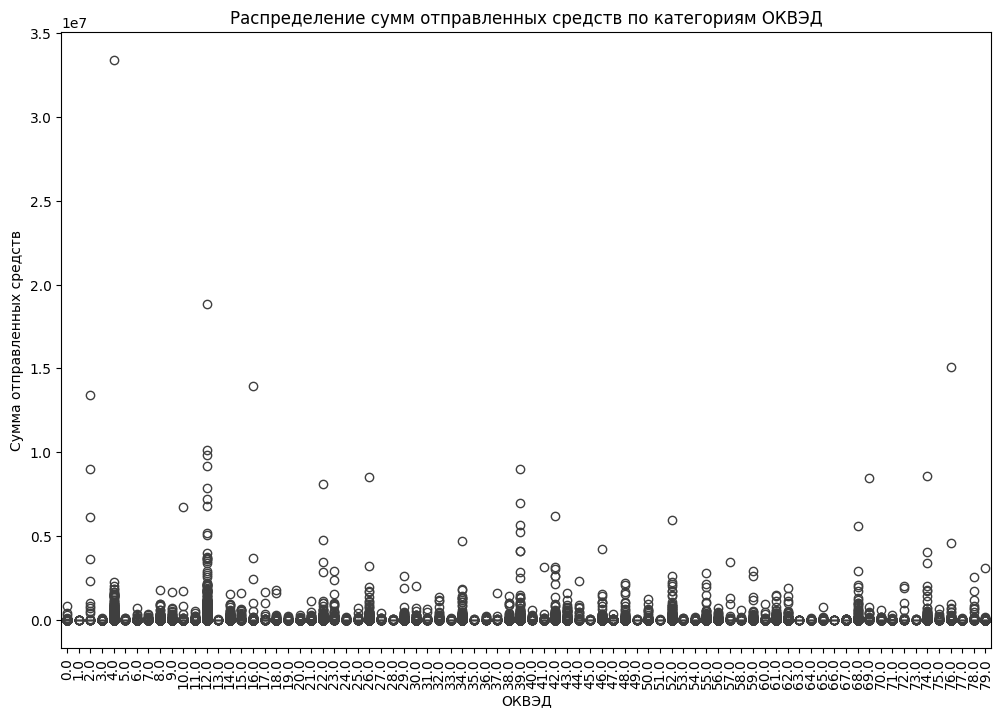

In [30]:
# Boxplot по ОКВЭД
plt.figure(figsize=(12, 8))
sns.boxplot(x='okved2', y='total_sent_sum', data=train_data)
plt.title('Распределение сумм отправленных средств по категориям ОКВЭД')
plt.xlabel('ОКВЭД')
plt.ylabel('Сумма отправленных средств')
plt.xticks(rotation=90)
plt.show()

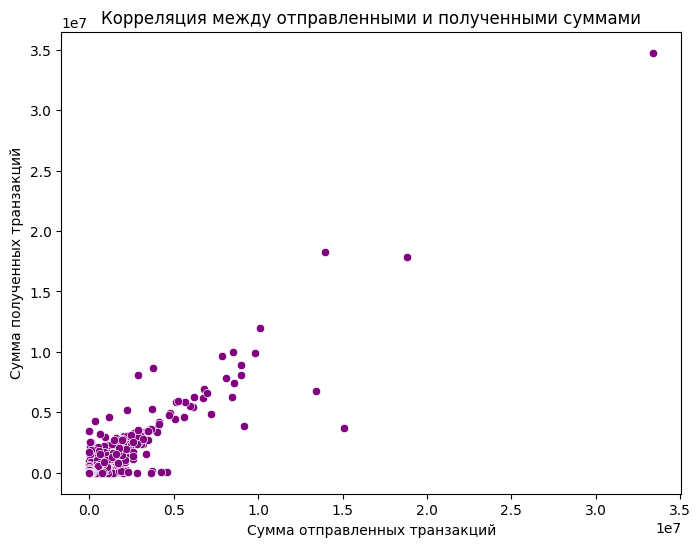

In [ ]:
# корреляция между отправленными и полученными транзакциями
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_data['total_sent_sum'], y=train_data['total_received_sum'], color='purple')
plt.title('Корреляция между отправленными и полученными суммами')
plt.xlabel('Сумма отправленных транзакций')
plt.ylabel('Сумма полученных транзакций')
plt.show()

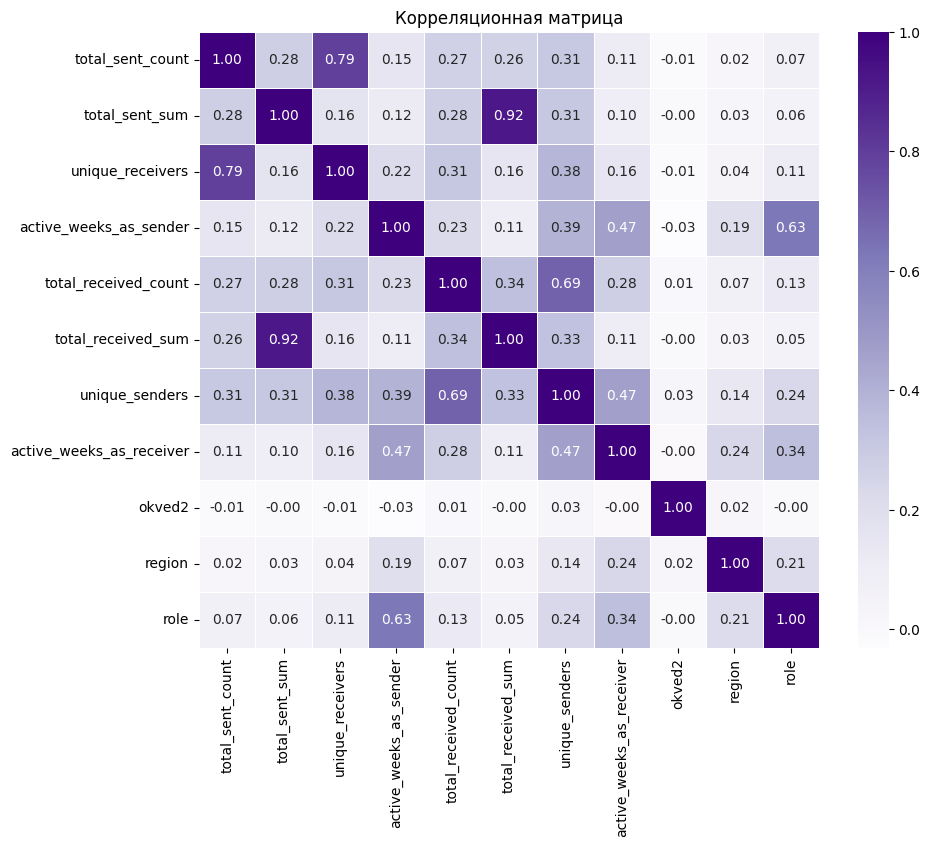

In [ ]:
# корреляционная матрица
corr_columns = ['total_sent_count', 'total_sent_sum', 'unique_receivers', 'active_weeks_as_sender', 'total_received_count', 
                   'total_received_sum', 'unique_senders', 'active_weeks_as_receiver', 'okved2', 'region', 'role']

corr_matrix = train_data[corr_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Purples', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

Корреляция total_received_sum и total_sent_sum практически равна 1, значит эти столбцы линейно зависимы и следует удалить один из них.

In [28]:
train_data = train_data.drop('total_sent_sum', axis=1)
target_data = target_data.drop('total_sent_sum', axis=1)

train_data.describe()

,total_sent_count,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,okved2,region,is_anomalous,role
count,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00,161415.00
mean,67.36,6.38,5.19,66.63,9150.79,6.28,6.50,28.41,58.91,0.02,2.06
std,989.98,55.87,6.97,432.46,163768.69,20.52,7.30,21.02,26.93,0.13,0.89
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,0.00,0.00,0.00,1.00,1.60,1.00,1.00,12.00,36.00,0.00,1.00
50%,3.00,1.00,2.00,6.00,60.68,1.00,3.00,17.00,60.00,0.00,2.00
75%,18.00,3.00,8.00,30.00,686.13,4.00,11.00,46.00,84.00,0.00,3.00
max,230374.00,10097.00,24.00,81795.00,34746612.93,1480.00,23.00,79.00,90.00,1.00,3.00


In [34]:
target_data.describe()

,total_sent_count,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,okved2,region,is_anomalous,role
count,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00
mean,63.32,5.93,5.20,64.82,8412.02,6.13,6.48,-1.00,59.00,0.02,2.06
std,662.99,39.63,6.97,348.59,134822.91,19.10,7.30,0.00,26.94,0.12,0.89
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.00,1.00,0.00,1.00
25%,0.00,0.00,0.00,1.00,1.60,1.00,1.00,-1.00,38.00,0.00,1.00
50%,3.00,1.00,2.00,6.00,61.62,1.00,3.00,-1.00,60.00,0.00,2.00
75%,19.00,3.00,8.00,30.00,668.97,4.00,11.00,-1.00,84.00,0.00,3.00
max,57753.00,2744.00,23.00,27774.00,14598625.43,842.00,23.00,-1.00,90.00,1.00,3.00


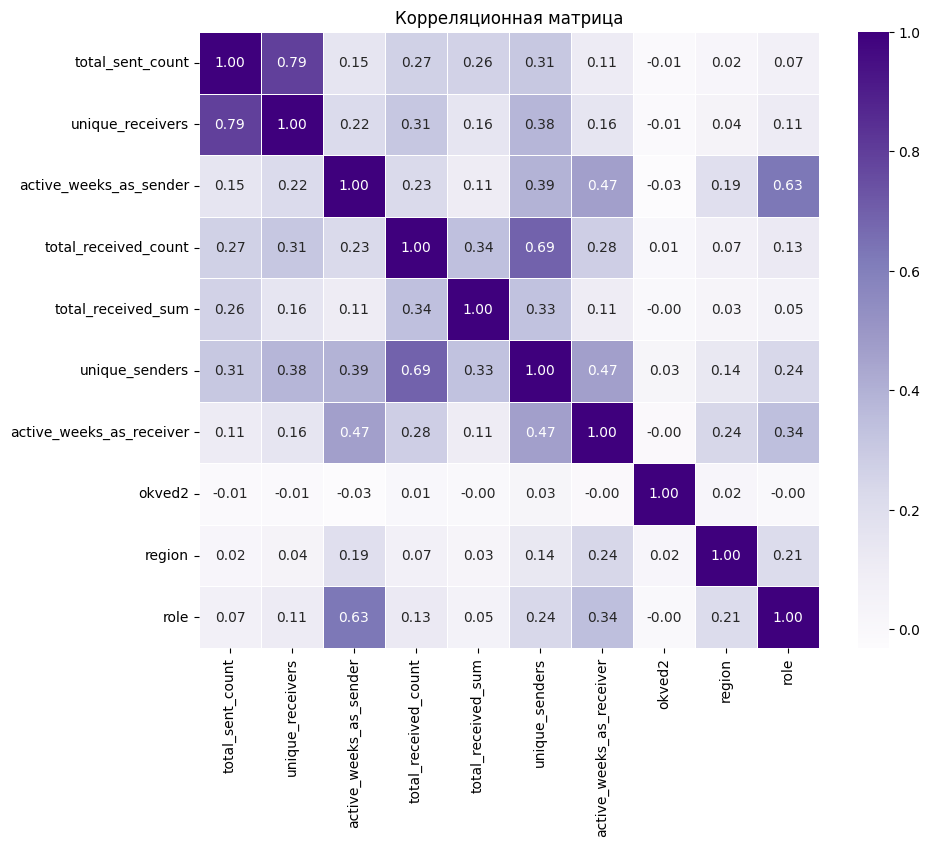

In [ ]:
# корреляционная матрица
corr_columns = ['total_sent_count', 'unique_receivers', 'active_weeks_as_sender', 'total_received_count', 
                   'total_received_sum', 'unique_senders', 'active_weeks_as_receiver', 'okved2', 'region', 'role']

corr_matrix = train_data[corr_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Purples', fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

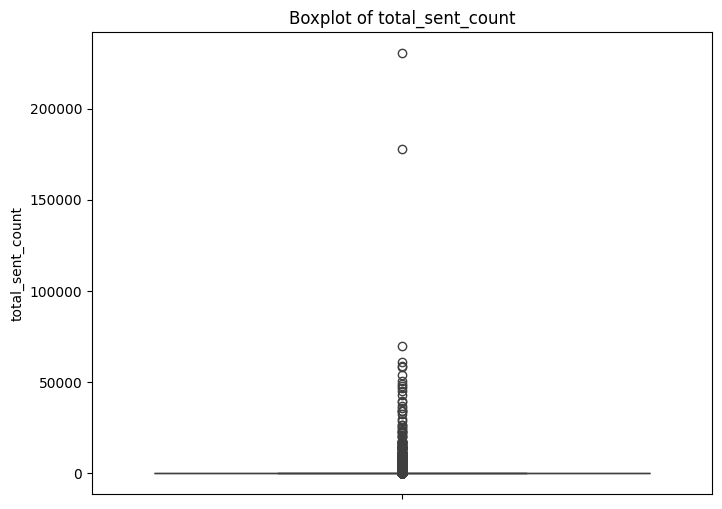

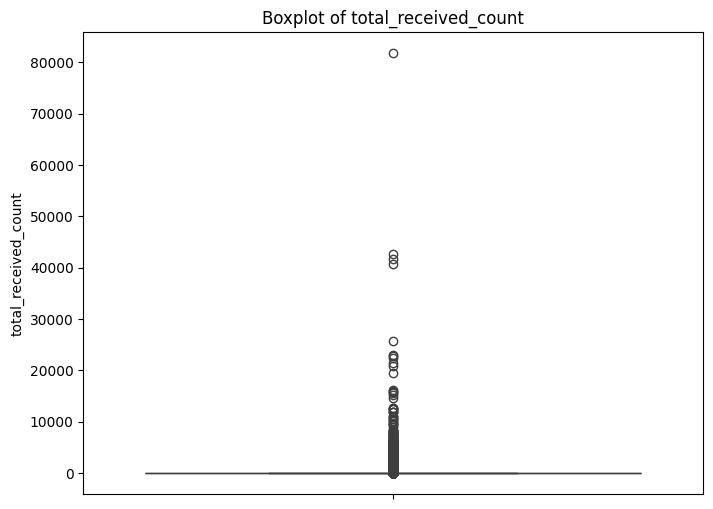

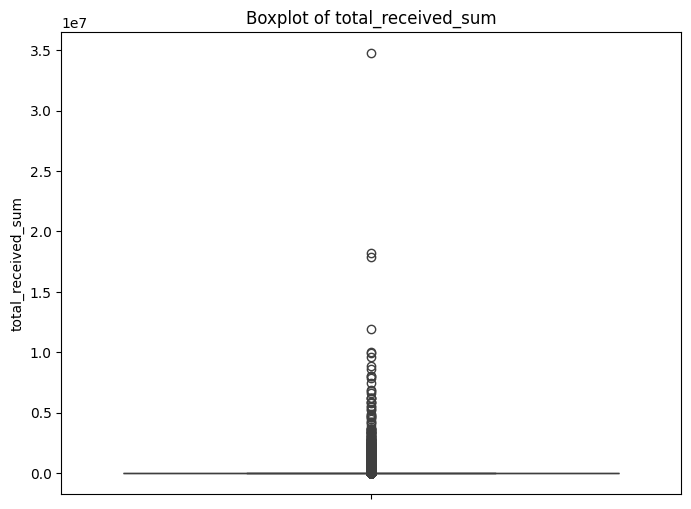

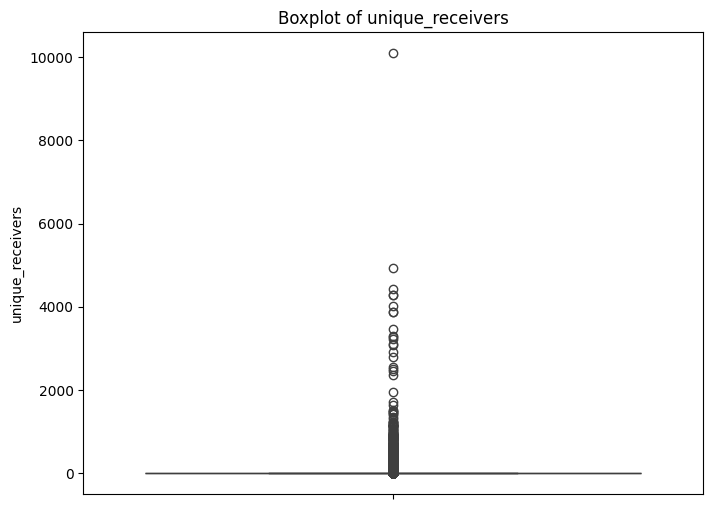

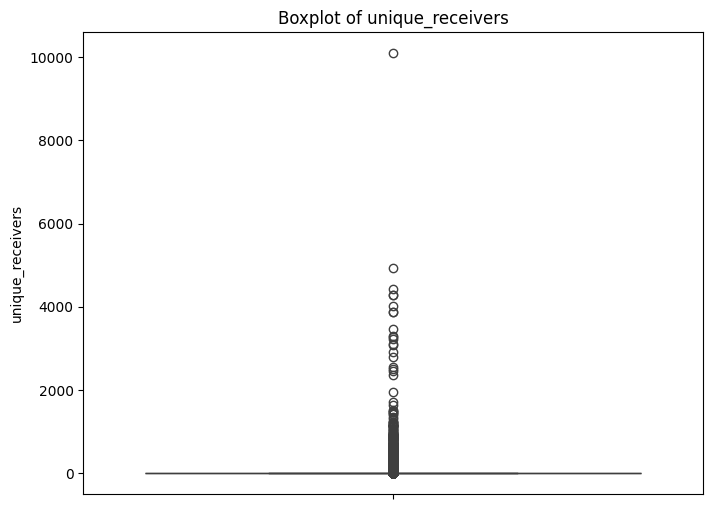

In [36]:
# Boxplots для транзакций
numeric_columns = ['total_sent_count', 'total_received_count', 'total_received_sum', 'unique_receivers', 'unique_receivers']

for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=train_data, y=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

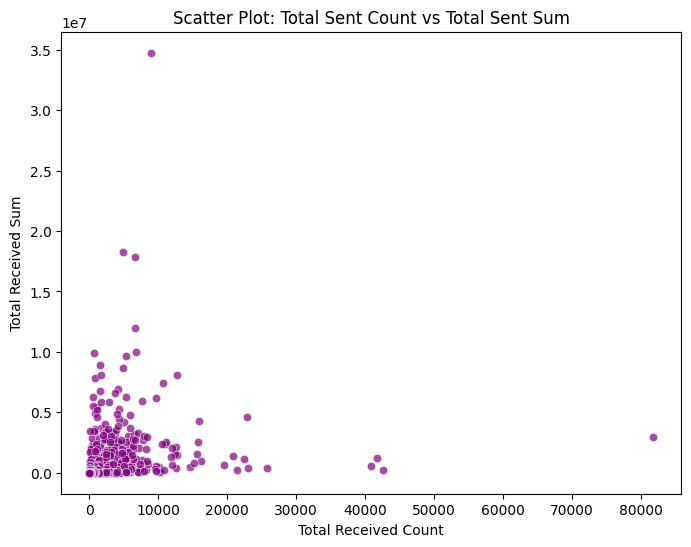

In [37]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_data, x='total_received_count', y='total_received_sum', alpha=0.7, color='purple')
plt.title('Scatter Plot: Total Sent Count vs Total Sent Sum')
plt.xlabel('Total Received Count')
plt.ylabel('Total Received Sum')
plt.show()

In [ ]:
# sns.pairplot(agg_data[['total_sent_count', 'total_sent_sum', 'total_received_count', 'total_received_sum']])
# plt.suptitle('Pairplot of Numeric Columns', y=1.02)
# plt.show()

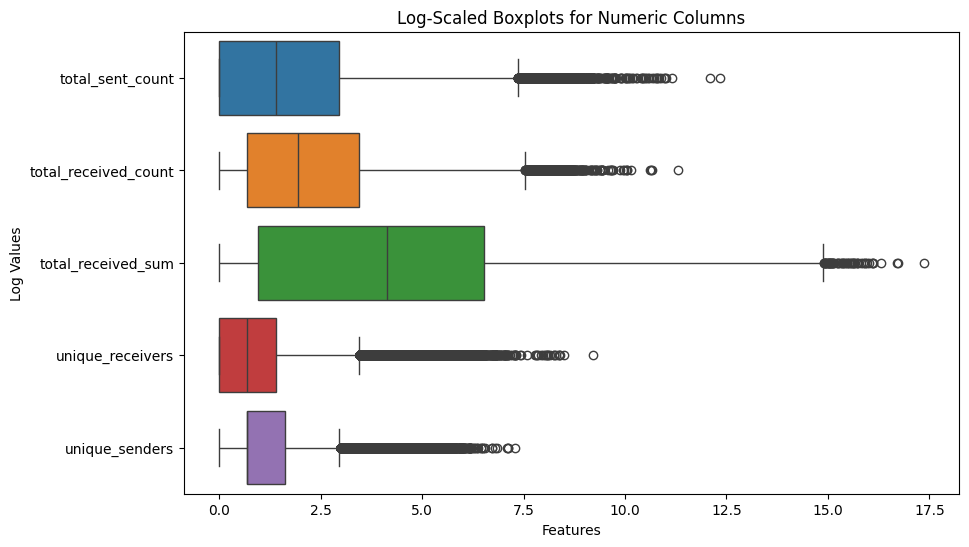

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=np.log1p(train_data[['total_sent_count', 'total_received_count', 'total_received_sum', 'unique_receivers', 'unique_senders']]), orient='h')
plt.title('Log-Scaled Boxplots for Numeric Columns')
plt.ylabel('Log Values')
plt.xlabel('Features')
plt.show()

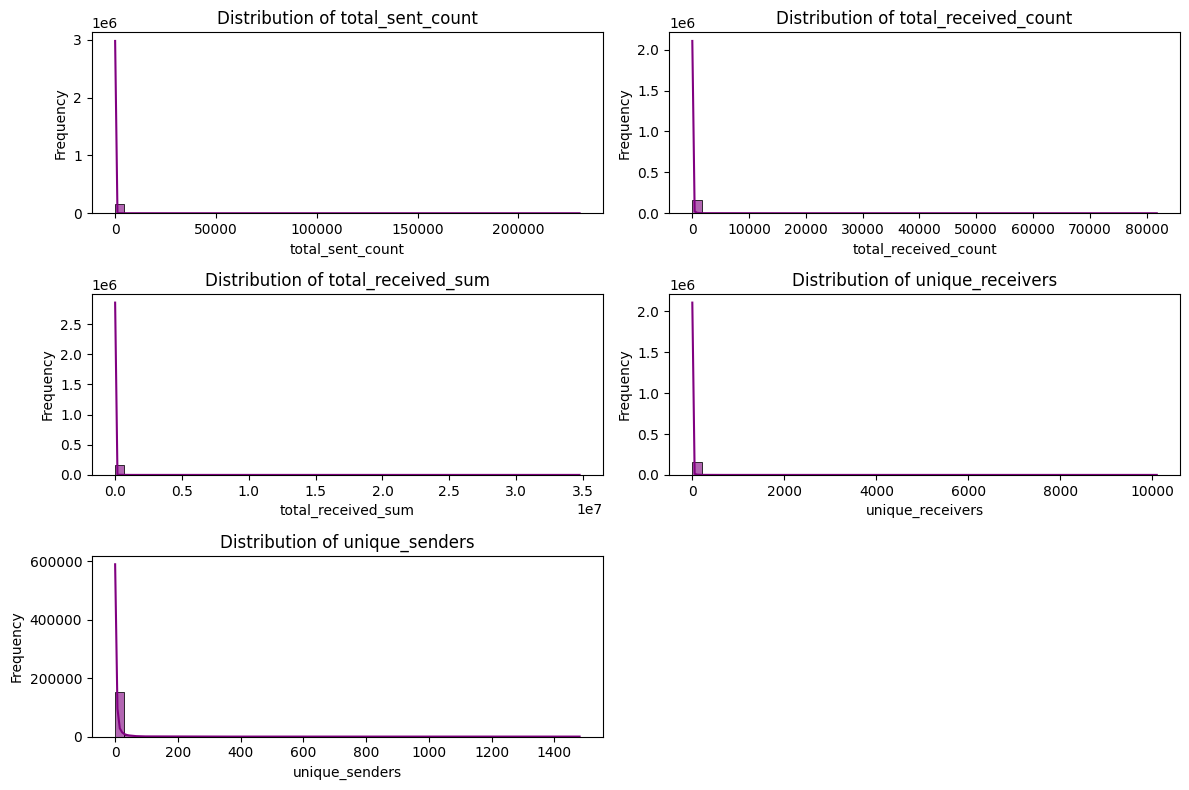

In [ ]:
plt.figure(figsize=(12, 8))

numeric_columns = ['total_sent_count', 'total_received_count', 'total_received_sum', 'unique_receivers', 'unique_senders']

# построение распределений для каждой колонки
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(train_data[col], kde=True, bins=50, color='purple', alpha=0.6)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


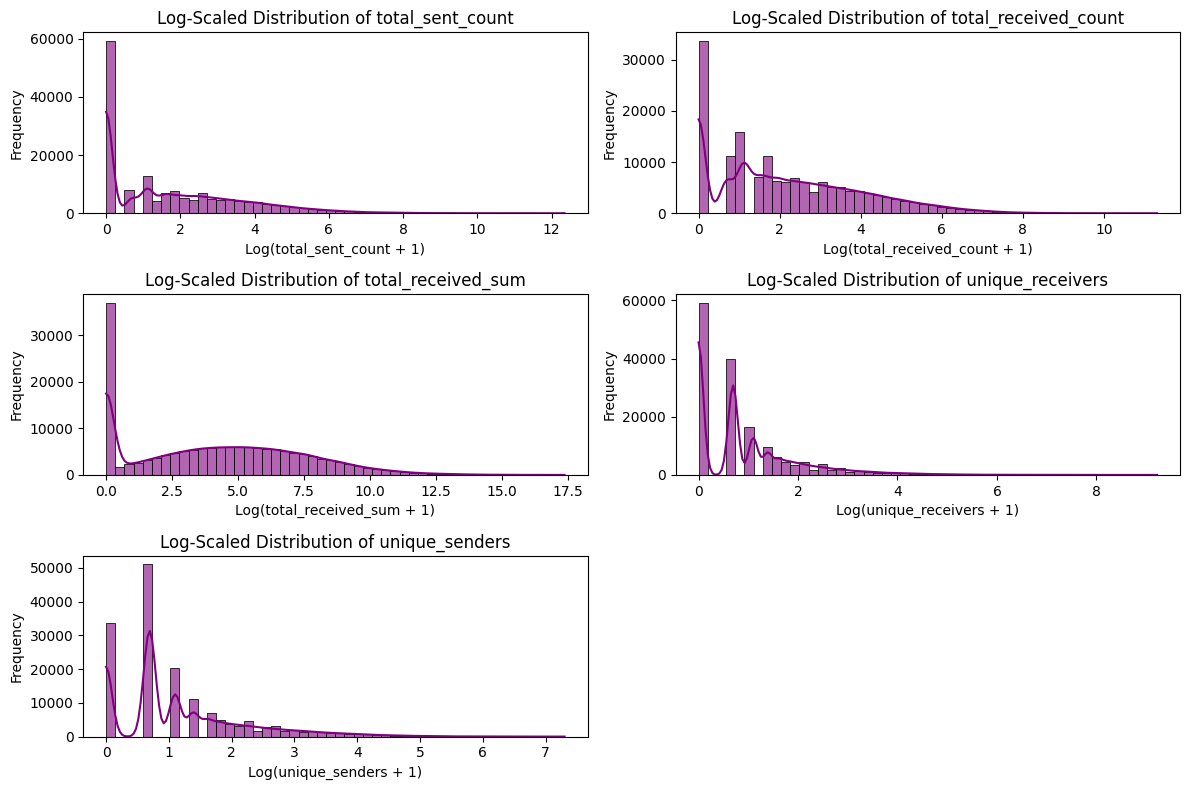

In [ ]:
plt.figure(figsize=(12, 8))

numeric_columns = ['total_sent_count', 'total_received_count', 'total_received_sum', 'unique_receivers', 'unique_senders']


# построение распределений для каждой колонки
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(np.log1p(train_data[col]), kde=True, bins=50, color='purple', alpha=0.6)
    plt.title(f'Log-Scaled Distribution of {col}')
    plt.xlabel(f'Log({col} + 1)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



Интерпретация по колонкам:

total_sent_count и total_received_count:
Большинство значений - маленькие (единичные транзакции).
Однако правый хвост указывает на компании с высокими показателями транзакционной активности.

total_received_sum:
Распределения явно указывают на редкие большие транзакции. Вопрос, являются ли они валидными или аномальными, зависит от контекста (то есть, к сожалению, неизвестно в рамках данной задачи).

unique_senders и unique_receivers:
Аналогично, большинство компаний взаимодействуют с небольшим числом контрагентов, однако присутствуют компании с высоким числом уникальных отправителей и получателей.

In [42]:
for col in numeric_columns:
    print(f'{col}: 95-й перцинтиль = {agg_data[col].quantile(0.95):.2f}, 99-й перцинтиль = {agg_data[col].quantile(0.99):.2f}')

total_sent_count: 95-й перцинтиль = 192.00, 99-й перцинтиль = 937.00
total_received_count: 95-й перцинтиль = 266.00, 99-й перцинтиль = 1014.00
total_received_sum: 95-й перцинтиль = 14051.17, 99-й перцинтиль = 123780.05
unique_receivers: 95-й перцинтиль = 20.00, 99-й перцинтиль = 87.00
unique_senders: 95-й перцинтиль = 27.00, 99-й перцинтиль = 82.00


Посмотрим несколько аналогичных графиков для целевой выборки, чтобы попытаться оценить, будут ли важны для нас аномально большие значения признаков

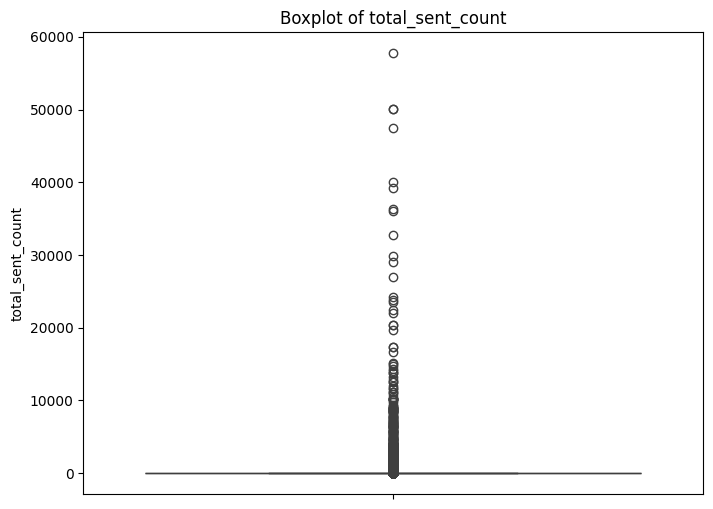

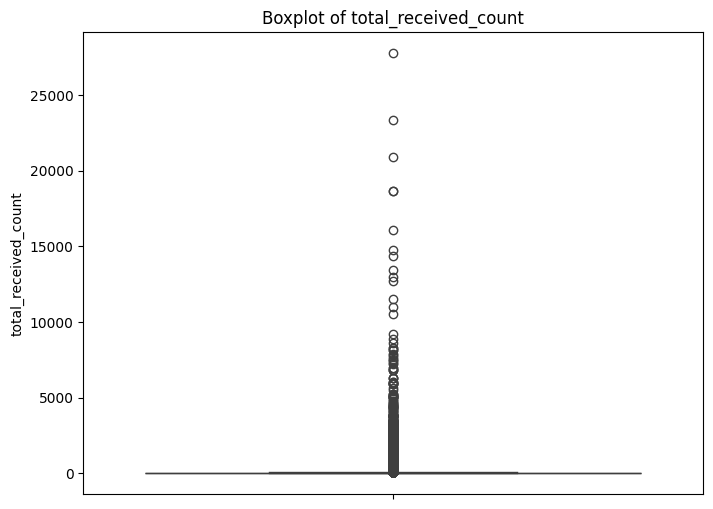

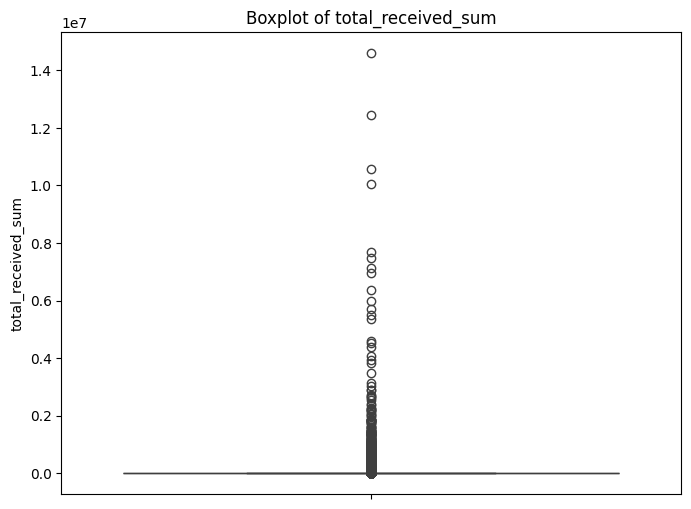

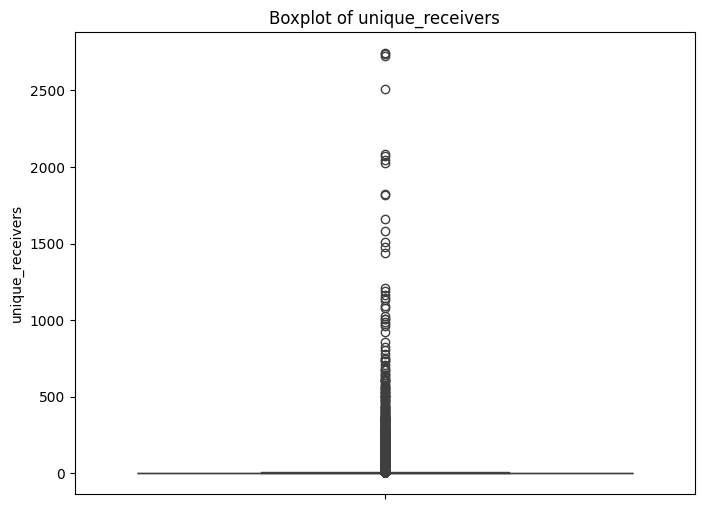

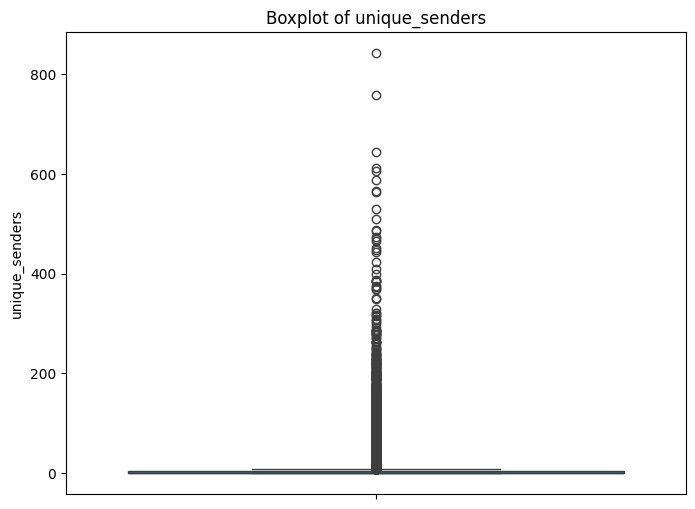

In [47]:
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=target_data, y=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.show()

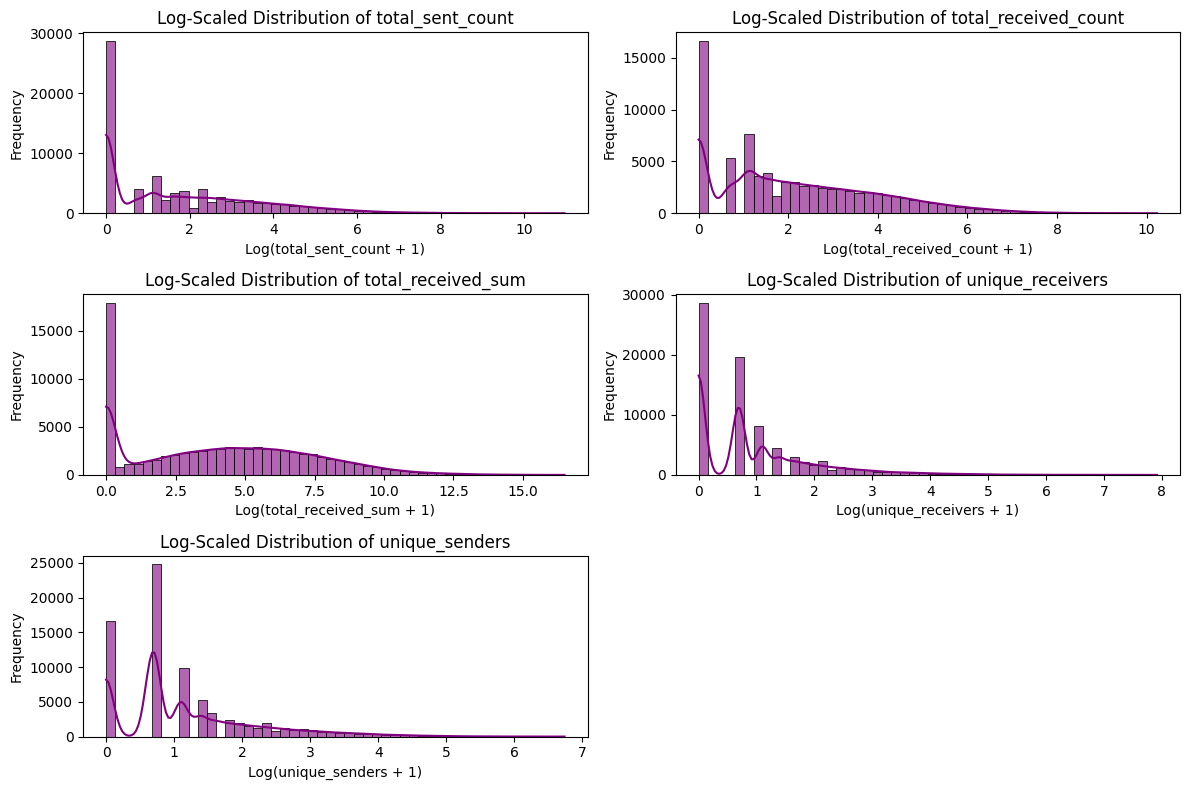

In [44]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(np.log1p(target_data[col]), kde=True, bins=50, color='purple', alpha=0.6)
    plt.title(f'Log-Scaled Distribution of {col}')
    plt.xlabel(f'Log({col} + 1)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [48]:
train_data['okved2'].value_counts()

okved2
12.00    44918
34.00    13654
14.00    10179
4.00      7617
52.00     6986
         ...  
2.00        90
36.00       84
13.00       68
73.00       64
1.00        50
Name: count, Length: 80, dtype: int64

In [ ]:
# для каждой колонки из numeric_columns находим 10 строк с максимальными значениями
for col in numeric_columns:
    print(f"Топ 10 значений для {col}:")
    top_values = train_data[['okved2', col]].nlargest(10, col)
    print(top_values)
    print("\n")


Топ 10 значений для total_sent_count:
       okved2  total_sent_count
13364    8.00         230374.00
69576   12.00         177969.00
99772   74.00          69503.00
36499    9.00          61069.00
43793   74.00          58625.00
33181   74.00          58086.00
23422   20.00          53605.00
77017   20.00          50752.00
73656    8.00          49019.00
87847   12.00          47923.00


Топ 10 значений для total_received_count:
       okved2  total_received_count
36092   34.00              81795.00
77384   22.00              42655.00
18490   22.00              41790.00
31164   34.00              40788.00
98613   34.00              25720.00
48428   76.00              23069.00
86798   12.00              22854.00
7234     4.00              22405.00
12104   14.00              21477.00
26512   68.00              20853.00


Топ 10 значений для total_received_sum:
       okved2  total_received_sum
32080    4.00         34746612.93
77246   16.00         18251759.39
33544   12.00         1787

Распределние обучающих и целевых данных похожи

Посмотрим, получится ли разделить данные на кластеры (в надежде, что такое разделение даст нам новые неочевидные полезные зависимости)

In [50]:
from sklearn.manifold import TSNE


In [29]:
X, y = train_data.drop(columns='okved2'), train_data['okved2']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [54]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train)

<Figure size 1000x800 with 0 Axes>

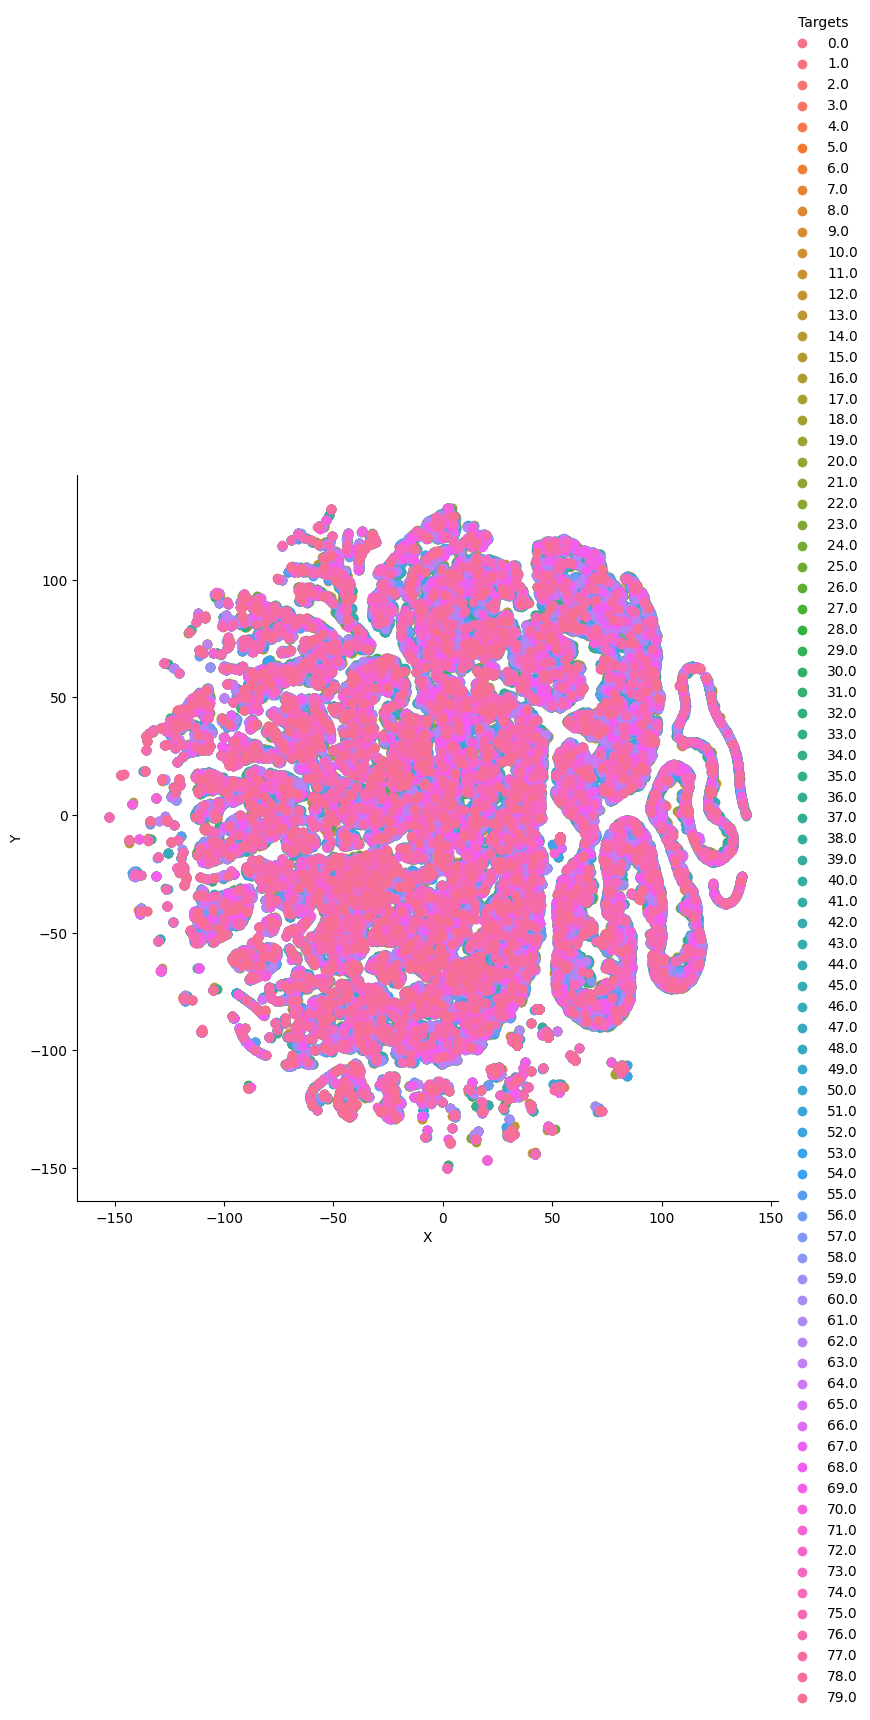

In [ ]:
tsne_df = pd.DataFrame(np.column_stack((X_embedded, y_train)), columns=['X', 'Y', "Targets"])

tsne_df.loc[:, "Targets"] = tsne_df.Targets.astype(int)
plt.figure(figsize=(10,8))

g = sns.FacetGrid(data=tsne_df, hue='Targets', height=8)
g.map(plt.scatter, 'X', 'Y').add_legend()

plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_train)

# Silhouette Score (учитываются только точки в кластерах)
silhouette_avg = silhouette_score(X_train[clusters != -1], clusters[clusters != -1])
print(f"Silhouette Score: {silhouette_avg}")


Silhouette Score: 0.7396292633390984


Похоже, данные можно кластеризовать!

In [ ]:
best_score = -1
best_eps = None
best_min_samples = None

eps_range = np.arange(0.1, 1.0, 0.1)  # радиус окрестности
min_samples_range = range(2, 20, 2)   # минимальное количество точек

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_train)

        # учитываем только точки, отнесённые к кластерам
        if len(set(clusters)) > 1 and len(np.unique(clusters[clusters != -1])) > 0:
            score = silhouette_score(X_train[clusters != -1], clusters[clusters != -1])
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples

print(f"Лучший Silhouette Score: {best_score}")
print(f"Лучшие параметры кластеризации: eps={best_eps}, min_samples={best_min_samples}")


Лучший Silhouette Score: 0.986201149745976
Лучшие параметры кластеризации: eps=0.1, min_samples=16


In [ ]:
dbscan = DBSCAN(eps=0.1, min_samples=16)
clusters = dbscan.fit_predict(X_train) #КАК РАЗ ЭТИ КЛАСТЕРЫ БУДУ ДАЛЬШЕ

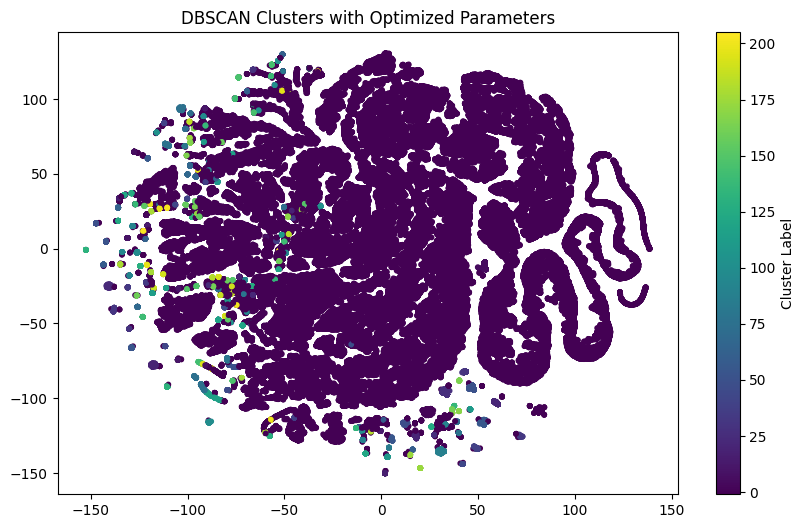

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_train)

plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clusters, cmap='viridis', s=10)
plt.title("DBSCAN Clusters with Optimized Parameters")
plt.colorbar(label='Cluster Label')
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix

contingency_table = pd.crosstab(y_train, clusters, rownames=['Actual'], colnames=['Cluster'])
print(contingency_table)


Cluster  -1     0     1     2     3     4     5     6     7     8    ...  \
Actual                                                               ...   
0.00      546     0     0     0     0     0     3     0     0     0  ...   
1.00       38     0     0     0     0     0     1     0     0     0  ...   
2.00       65     0     0     0     0     0     0     0     0     0  ...   
3.00      531     0     3     0     2     2    11     1     0     1  ...   
4.00     5248    11     8     1     1     3    37     6     0     0  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
75.00     136     0     0     0     0     0     0     0     0     0  ...   
76.00    1315     7     4     2     1     1    27     2     1     0  ...   
77.00     448     0     0     0     0     0     2     0     0     0  ...   
78.00     284     0     0     0     0     0     1     0     0     2  ...   
79.00     634     3     4     0     0     0     7     0     0     0  ...   

Cluster   1

In [ ]:
unique_clusters = np.unique(clusters)

# количество кластеров, исключая шум (если есть метка -1)
n_clusters = len(unique_clusters[unique_clusters != -1])

print(f"Всего кластеров: {len(unique_clusters)}")
print(f"Кластеров без учета шума: {n_clusters}")

Всего кластеров: 207
Кластеров без учета шума: 206


C:\Users\Ксения\AppData\Local\Temp\ipykernel_11992\1503429600.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=distribution.index, y=distribution.values, palette='viridis')


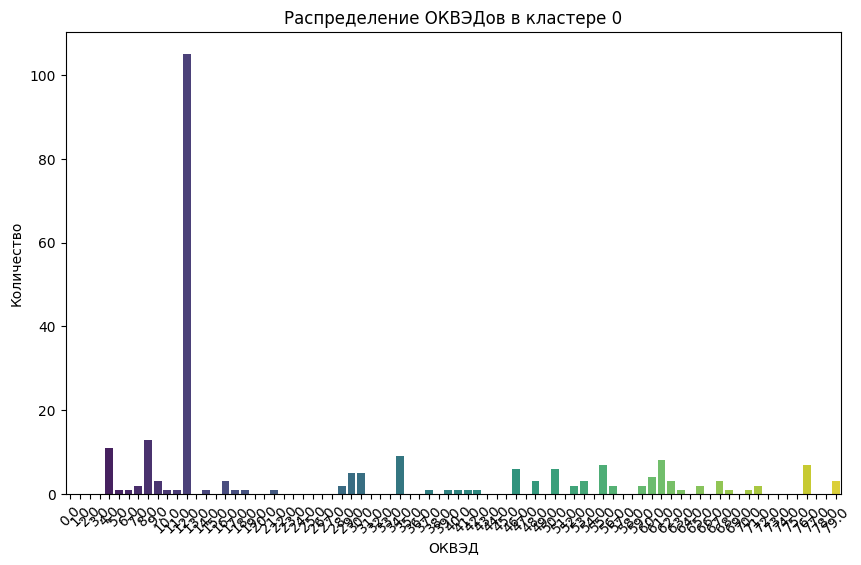

In [ ]:
# визуализация распределения ОКВЭДов в конкретном кластере
cluster_id = 0  # например, для первого кластера
distribution = contingency_table[cluster_id].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=distribution.index, y=distribution.values, palette='viridis')
plt.title(f"Распределение ОКВЭДов в кластере {cluster_id}")
plt.xlabel("ОКВЭД")
plt.ylabel("Количество")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# для каждого кластера — топ-15 ОКВЭДов
for cluster_id in sorted(np.unique(clusters)):
    top_classes = contingency_table[cluster_id].sort_values(ascending=False).head(15)
    print(f"Кластер {cluster_id}:")
    print(top_classes)
    print("-" * 30)

Кластер -1:
Actual
12.00    30091
34.00     9674
14.00     7175
4.00      5248
52.00     4948
55.00     3761
8.00      3128
62.00     2350
26.00     2241
61.00     2219
11.00     2097
46.00     1928
39.00     1863
6.00      1762
56.00     1573
Name: -1, dtype: int64
------------------------------
Кластер 0:
Actual
12.00    105
8.00      13
4.00      11
34.00      9
61.00      8
76.00      7
55.00      7
46.00      6
50.00      6
30.00      5
29.00      5
60.00      4
79.00      3
48.00      3
53.00      3
Name: 0, dtype: int64
------------------------------
Кластер 1:
Actual
12.00    134
34.00     16
30.00     11
52.00     10
46.00      9
4.00       8
8.00       6
9.00       6
56.00      6
16.00      6
7.00       6
50.00      5
48.00      5
71.00      5
29.00      5
Name: 1, dtype: int64
------------------------------
Кластер 2:
Actual
12.00    5
76.00    2
56.00    2
71.00    2
15.00    1
46.00    1
4.00     1
18.00    1
34.00    1
16.00    1
58.00    0
57.00    0
55.00    0
54.00    

Попробуем нормализовать данные и кластеризовать их ещё раз с целью улучшения качества кластеризации (к тому же, все данные в модель будут подаваться предобработанными), но искусственно ограничим число кластеров числом классов (вдруг получится разделить данные более близко к распределению по классам)

In [41]:
standart_scaler = StandardScaler()
X_train_scaled = standart_scaler.fit_transform(X_train)

In [44]:
best_score = -1
best_eps = None
best_min_samples = None
best_clusters = None

eps_range = np.arange(0.1, 1.0, 0.1)
min_samples_range = range(2, 20, 2)

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_train_scaled)

        num_clusters = len(np.unique(clusters)) - (1 if -1 in clusters else 0)

        if num_clusters > 1 and num_clusters <= 80:
            score = silhouette_score(X_train_scaled[clusters != -1], clusters[clusters != -1])
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_clusters = num_clusters
        else: 
            continue

print(f"Лучший Silhouette Score: {best_score}")
print(f"Лучшие параметры кластеризации: eps={best_eps}, min_samples={best_min_samples}")
print(f'Число кластеров с лучшей метрикой: {best_clusters}')


: 

Зря перезапустила. С прошлого прогона сохранились наилучшие параметры для кластеризации:
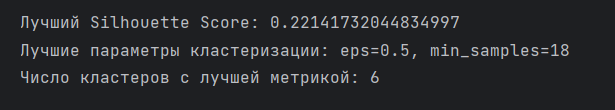

Добавим логарифмическое преобразование (логарифмическое преобразование должно быть первым: оно сгладит данные и уменьшит разброс). Нормализация сработает лучше, если данные уже будут иметь примерно одинаковый порядок величин.
Если сначала нормализовать, а затем логарифмировать, то нормализация "сплющит" данные в заданный диапазон и логарифмирование может стать уже не таким эффективным

In [ ]:
X_train_log = X_train
numeric_columns = ['total_sent_count', 'total_received_count', 'total_received_sum', 'unique_receivers', 'unique_senders']

for col in numeric_columns:
    X_train_log[col] = X_train_log[col].apply(lambda x: np.log1p(x))  # логирования +1 для обработки 0 значений

X_train_log.describe()

,total_sent_count,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,region,is_anomalous,role
count,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00
mean,1.76,0.93,5.19,2.19,4.13,1.16,6.48,58.93,0.02,2.06
std,1.84,1.05,6.95,1.82,3.24,1.05,7.30,26.95,0.13,0.89
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,0.00,0.00,0.00,0.69,0.95,0.69,1.00,36.00,0.00,1.00
50%,1.39,0.69,2.00,1.95,4.11,0.69,3.00,60.00,0.00,2.00
75%,2.94,1.39,8.00,3.43,6.52,1.61,11.00,84.00,0.00,3.00
max,12.35,9.22,24.00,10.66,17.36,7.30,23.00,90.00,1.00,3.00


In [34]:
standart_scaler = StandardScaler()

X_train_log_scaled = pd.DataFrame(
    standart_scaler.fit_transform(X_train_log),
    columns=X_train_log.columns,  
    index=X_train_log.index       
)
X_train_log_scaled.describe()

,total_sent_count,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,region,is_anomalous,role
count,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00,121061.00
mean,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.96,-0.89,-0.75,-1.20,-1.28,-1.11,-0.89,-2.19,-0.13,-1.20
25%,-0.96,-0.89,-0.75,-0.82,-0.98,-0.45,-0.75,-0.85,-0.13,-1.20
50%,-0.20,-0.23,-0.46,-0.14,-0.01,-0.45,-0.48,0.04,-0.13,-0.07
75%,0.65,0.43,0.40,0.68,0.74,0.43,0.62,0.93,-0.13,1.06
max,5.76,7.90,2.71,4.64,4.09,5.87,2.26,1.15,7.51,1.06


Большее число классов, возможно, позволит выявить локальные паттерны в данных, а также DBSCAN выделяет "шумовой" класс, что, возможно, будет полезно. К тому же искусственное ограничение числа кластеров только навредило

In [83]:
best_score = -1
best_eps = None
best_min_samples = None
best_clusters = None

eps_range = np.arange(0.1, 1.0, 0.1)
min_samples_range = range(2, 20, 2)

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_train_log_scaled)

        num_clusters = len(np.unique(clusters)) - (1 if -1 in clusters else 0)

        if num_clusters > 1:
            score = silhouette_score(X_train_log_scaled[clusters != -1], clusters[clusters != -1])
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_clusters = num_clusters

print(f"Лучший Silhouette Score: {best_score}")
print(f"Лучшие параметры кластеризации: eps={best_eps}, min_samples={best_min_samples}")
print(f'Число кластеров с лучшей метрикой: {best_clusters}')


Лучший Silhouette Score: 0.3034199837045169
Лучшие параметры кластеризации: eps=0.7000000000000001, min_samples=14
Число кластеров с лучшей метрикой: 7


In [35]:
X_val_log = X_val
for col in numeric_columns:
    X_val_log[col] = X_val_log[col].apply(lambda x: np.log1p(x)) 

X_val_log_scaled = pd.DataFrame(
    standart_scaler.fit_transform(X_val_log),
    columns=X_val_log.columns,  
    index=X_val_log.index       
)
X_val_log_scaled.describe()

,total_sent_count,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,region,is_anomalous,role
count,40354.00,40354.00,40354.00,40354.00,40354.00,40354.00,40354.00,40354.00,40354.00,40354.00
mean,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.95,-0.88,-0.74,-1.21,-1.29,-1.12,-0.89,-2.15,-0.13,-1.18
25%,-0.95,-0.88,-0.74,-0.83,-0.98,-0.45,-0.76,-0.81,-0.13,-1.18
50%,-0.35,-0.22,-0.46,-0.14,-0.00,-0.45,-0.48,0.04,-0.13,-0.06
75%,0.64,0.43,0.40,0.67,0.75,0.42,0.61,0.94,-0.13,1.07
max,4.98,7.04,2.54,4.99,3.89,5.70,2.25,1.16,7.45,1.07


Попробуем добавить метки кластеров в качестве нового признака

In [ ]:
best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
best_clusters = dbscan.fit_predict(X_train_log_scaled)

In [36]:
X_train_log_scaled['clusters'] = clusters

По-хорошему, при использовании DBSCAN (а его удобно использовать, так как у нас сложное распределение данных и этот метод кластеризации умеет находить кластеры сложной формы) для кластеризации новых объектов нужно обучать модель на старых + новых данных, но это может стать причиной утечки данных из тестовых и целевых данных. Поэтому придется "кластеризовать" новые данные локально: для каждой новой точки будем искать ближайший центр кластера, смотреть, попадает ли она в этот кластер и или присваивать ей номер этого кластера, или ставить метку -1 ("шум").

In [ ]:
# вычислим центров кластеров
clusters_info = {}
cluster_points = None

for label in X_train_log_scaled['clusters'].unique():
    if label != -1:  # Исключаем шум
        # фильтруем точки, принадлежащие текущему кластеру
        cluster_points = X_train_log_scaled[X_train_log_scaled['clusters'] == label].drop(columns=['clusters']).values
        
        # сохраняем информацию о центре и размере
        clusters_info[label] = {
            'center': np.mean(cluster_points, axis=0),
            'size': len(cluster_points)  # размер кластера
        }

# сохраним центры кластеров в массив
cluster_centers = np.array([info['center'] for info in clusters_info.values()])
cluster_labels = np.array(list(clusters_info.keys()))

In [38]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
nn = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')
nn.fit(cluster_centers)

# для каждой точки находим ближайший центр
distances, indices = nn.kneighbors(X_val_log_scaled.values)  # расстояния и индексы ближайших центров

# проверяем, входит ли точка в радиус кластера
eps = 0.1
cluster_assignments = []

for i, distance in enumerate(distances.flatten()):
    if distance <= eps:
        cluster_assignments.append(cluster_labels[indices[i][0]])  # метка ближайшего кластера
    else:
        cluster_assignments.append(-1)  # метка шума

# добавляем метки кластеров в DataFrame
X_val_log_scaled['clusters'] = cluster_assignments

In [41]:
X_target = target_data.drop(columns=['okved2'])
X_target_log = X_target
for col in numeric_columns:
    X_target_log[col] = X_target_log[col].apply(lambda x: np.log1p(x)) 

X_target_log_scaled = pd.DataFrame(
    standart_scaler.fit_transform(X_target_log),
    columns=X_target_log.columns,  
    index=X_target_log.index       
)
X_target_log_scaled.describe()

,total_sent_count,unique_receivers,active_weeks_as_sender,total_received_count,total_received_sum,unique_senders,active_weeks_as_receiver,region,is_anomalous,role
count,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00,78654.00
mean,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.96,-0.89,-0.75,-1.20,-1.28,-1.11,-0.89,-2.15,-0.13,-1.20
25%,-0.96,-0.89,-0.75,-0.82,-0.99,-0.45,-0.75,-0.78,-0.13,-1.20
50%,-0.20,-0.23,-0.46,-0.13,0.00,-0.45,-0.48,0.04,-0.13,-0.07
75%,0.67,0.44,0.40,0.68,0.74,0.43,0.62,0.93,-0.13,1.06
max,5.02,6.69,2.55,4.42,3.84,5.37,2.26,1.15,7.93,1.06


In [42]:
distances, indices = nn.kneighbors(X_target_log_scaled.values)

cluster_assignments = []

for i, distance in enumerate(distances.flatten()):
    if distance <= eps:
        cluster_assignments.append(cluster_labels[indices[i][0]]) 
    else:
        cluster_assignments.append(-1)

X_target_log_scaled['clusters'] = cluster_assignments

Классификация!

In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV

In [92]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=3, random_state=42, n_jobs=-1)

random_search.fit(X_train_log_scaled, y_train)

print("Лучшие параметры: ", random_search.best_params_)

y_val_pred = random_search.predict(X_val_log_scaled)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

c:\Users\Ксения\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ксения\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Ксения\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\Ксения\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.

Лучшие параметры:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
Accuracy: 0.307825742181692
F1 Score: 0.17606899633281992
Confusion Matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Лучшие параметры:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}

In [46]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=10, random_state=42)
rf.fit(X_train_log_scaled, y_train)

y_val_pred = rf.predict(X_val_log_scaled)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("F1 Score:", f1_score(y_val, y_val_pred, average='weighted'))

y_target_pred = rf.predict(X_target_log_scaled)

hash_inn = agg_data[agg_data['okved2'] == -1]['hash_inn'].reset_index(drop=True)
submission = pd.DataFrame({'hash_inn': hash_inn, 'y': y_target_pred})
submission.to_csv('C:/Users/Ксения/PycharmProjects/deep_learning/vscode/KseniaPolekhina-18112024-SberIndustry_rf.csv', index=False)

Accuracy: 0.3081478911632056
F1 Score: 0.1770333355689248


In [93]:
# y_target_pred = rf.predict(X_target_log_scaled)

# hash_inn = agg_data[agg_data['okved2'] == -1]['hash_inn'].reset_index(drop=True)
# submission = pd.DataFrame({'hash_inn': hash_inn, 'y': y_target_pred})
# submission.to_csv('KseniaPolekhina-18112024-SberIndustry_rf.csv', index=False)

Попробуем прогнать данные через простенькую многослойную полносвязную нейронную сеть

In [47]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [48]:
torch.cuda.is_available()

True

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
X_train_tensor = torch.tensor(X_train_log_scaled.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_log_scaled.values, dtype=torch.float32)
X_target_tensor = torch.tensor(X_target_log_scaled.values, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

In [51]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [52]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.hidden2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.hidden3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(128, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.hidden1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.hidden2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.hidden3(x)))
        x = self.dropout(x)
        x = self.output(x)
        return x

In [ ]:
def train_model(model, train_loader, criterion, optimizer, epochs):
    """
    Функция для обучения модели.
    """
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")

        # оценка модели на валидационном наборе после каждой эпохи
        val_preds = evaluate_model(model, val_loader)
        val_accuracy = accuracy_score(y_val, val_preds)
        val_f1 = f1_score(y_val, val_preds, average='weighted')
        print(f"Validation Accuracy после эпохи {epoch+1}: {val_accuracy:.4f}")
        print(f"Validation F1 Score после эпохи {epoch+1}: {val_f1:.4f}")


In [ ]:
def evaluate_model(model, data_loader):
    """
    Функция для оценки модели на данных.
    """
    model.eval()
    all_preds = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy()) # перемещаем обратно на CPU для подсчета
    
    accuracy = correct / total

    return all_preds


In [ ]:
# размеры входа и выхода
input_dim = X_train_log_scaled.shape[1]
output_dim = len(np.unique(y_train))

model = MLP(input_dim=input_dim, output_dim=output_dim).to(device)

# определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, epochs=150)

y_val_pred = evaluate_model(model, val_loader)

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Validation Accuracy: {accuracy}")
print(f"Validation F1 Score: {f1}")

X_target_tensor = X_target_tensor.to(device)

# оценка на тестовых данных
model.eval()
with torch.no_grad():
    outputs = model(X_target_tensor)
    _, y_target_pred = torch.max(outputs, 1)
    y_target_pred = y_target_pred.cpu()

submission = pd.DataFrame({
    'hash_inn': agg_data[agg_data['okved2'] == -1].reset_index(drop=True)['hash_inn'],
    'okved2': y_target_pred.numpy()
})

submission.to_csv('C:/Users/Ксения/PycharmProjects/deep_learning/vscode/KseniaPolekhina-18112024-SberIndustry_nn.csv', index=False)
print("Submission file saved!")


Epoch 1/150, Loss: 3.220609087772652
Validation Accuracy после эпохи 1: 0.3006
Validation F1 Score после эпохи 1: 0.1676
Epoch 2/150, Loss: 3.138099497392868
Validation Accuracy после эпохи 2: 0.3033
Validation F1 Score после эпохи 2: 0.1698
Epoch 3/150, Loss: 3.116591008596642
Validation Accuracy после эпохи 3: 0.3017
Validation F1 Score после эпохи 3: 0.1647
Epoch 4/150, Loss: 3.1052735793162096
Validation Accuracy после эпохи 4: 0.3049
Validation F1 Score после эпохи 4: 0.1724
Epoch 5/150, Loss: 3.094733121279178
Validation Accuracy после эпохи 5: 0.3029
Validation F1 Score после эпохи 5: 0.1660
Epoch 6/150, Loss: 3.0873694385837047
Validation Accuracy после эпохи 6: 0.3044
Validation F1 Score после эпохи 6: 0.1712
Epoch 7/150, Loss: 3.082517608023597
Validation Accuracy после эпохи 7: 0.3052
Validation F1 Score после эпохи 7: 0.1733
Epoch 8/150, Loss: 3.0788108274246118
Validation Accuracy после эпохи 8: 0.3046
Validation F1 Score после эпохи 8: 0.1724
Epoch 9/150, Loss: 3.07468048

In [ ]:

input_dim = X_train_log_scaled.shape[1]
output_dim = len(np.unique(y_train))

model = MLP(input_dim=input_dim, output_dim=output_dim).to(device)

# определяем функцию потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_model(model, train_loader, criterion, optimizer, epochs=150)

y_val_pred = evaluate_model(model, val_loader)

accuracy = accuracy_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred, average='weighted')

print(f"Validation Accuracy: {accuracy}")
print(f"Validation F1 Score: {f1}")

X_target_tensor = X_target_tensor.to(device)

# оценка на тестовых данных
model.eval()
with torch.no_grad():
    outputs = model(X_target_tensor)
    _, y_target_pred = torch.max(outputs, 1)
    y_target_pred = y_target_pred.cpu()

submission = pd.DataFrame({
    'hash_inn': agg_data[agg_data['okved2'] == -1].reset_index(drop=True)['hash_inn'],
    'okved2': y_target_pred.numpy()
})

submission.to_csv('C:/Users/Ксения/PycharmProjects/deep_learning/vscode/KseniaPolekhina-18112024-SberIndustry_nn2.csv', index=False)
print("Submission file saved!")


Epoch 1/150, Loss: 3.182018317581483
Validation Accuracy после эпохи 1: 0.2981
Validation F1 Score после эпохи 1: 0.1592
Epoch 2/150, Loss: 3.1221731897388403
Validation Accuracy после эпохи 2: 0.2975
Validation F1 Score после эпохи 2: 0.1562
Epoch 3/150, Loss: 3.117214579032793
Validation Accuracy после эпохи 3: 0.3000
Validation F1 Score после эпохи 3: 0.1591
Epoch 4/150, Loss: 3.1143924246126704
Validation Accuracy после эпохи 4: 0.3016
Validation F1 Score после эпохи 4: 0.1678
Epoch 5/150, Loss: 3.114717109888855
Validation Accuracy после эпохи 5: 0.2989
Validation F1 Score после эпохи 5: 0.1582
Epoch 6/150, Loss: 3.112894701655269
Validation Accuracy после эпохи 6: 0.3001
Validation F1 Score после эпохи 6: 0.1601
Epoch 7/150, Loss: 3.114577974375912
Validation Accuracy после эпохи 7: 0.2993
Validation F1 Score после эпохи 7: 0.1601
Epoch 8/150, Loss: 3.1122256008313522
Validation Accuracy после эпохи 8: 0.2980
Validation F1 Score после эпохи 8: 0.1583
Epoch 9/150, Loss: 3.11019514

In [ ]:
# X_train_log_scaled = standart_scaler.fit_transform(X_train_log)

In [ ]:
# # Сохранение лучших параметров
# best_score = -1
# best_eps = None
# best_min_samples = None
# best_clusters = None

# # Диапазоны для параметров
# eps_range = np.arange(0.1, 1.0, 0.1)
# min_samples_range = range(2, 20, 2)

# # Перебор параметров
# for eps in eps_range:
#     for min_samples in min_samples_range:
#         dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#         clusters = dbscan.fit_predict(X_train_scaled)

#         num_clusters = len(np.unique(clusters)) - (1 if -1 in clusters else 0)

#         # Учитываем только точки, отнесённые к кластерам
#         if num_clusters > 1 and num_clusters <= 80:
#             score = silhouette_score(X_train_scaled[clusters != -1], clusters[clusters != -1])
#             if score > best_score:
#                 best_score = score
#                 best_eps = eps
#                 best_min_samples = min_samples
#                 best_clusters = num_clusters
#         else: 
#             continue

# print(f"Лучший Silhouette Score: {best_score}")
# print(f"Лучшие параметры кластеризации: eps={best_eps}, min_samples={best_min_samples}")
# print(f'Число кластеров с лучшей метрикой: {best_clusters}')


In [ ]:
# smote = SMOTE()
# X_train, y_train = smote.fit_resample(X_train, y_train)

# y_train.value_counts()

In [ ]:
# for col in numeric_columns:
#     train_data[col] = train_data[col].apply(lambda x: np.log1p(x))  # Логирования +1 для обработки 0 значений
#     target_data[col] = target_data[col].apply(lambda x: np.log1p(x))

In [ ]:
# for col in numeric_columns:
#     X_train[col] = X_train[col].apply(lambda x: np.log1p(x))  
#     X_val[col] = X_val[col].apply(lambda x: np.log1p(x))  


In [ ]:
# train_data['unique_receivers'] = train_data[col].apply(lambda x: np.log1p(x))
# target_data["unique_receivers"] = target_data[col].apply(lambda x: np.log1p(x))

In [ ]:
# train_data['unique_senders'] = train_data[col].apply(lambda x: np.log1p(x))
# target_data["unique_senders"] = target_data[col].apply(lambda x: np.log1p(x))

In [ ]:
# X = train_data.drop(columns=['okved2'])
# y = train_data['okved2']
  
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# y_train.value_counts()